# Set Parameters

In [ ]:
PAT_NOW = "S23_199"
PAT_SHORT_NAME = PAT_NOW[0:1] + PAT_NOW[3:] # e.g. "S_199"

VIDEO_TIMESTAMPS_FILE_PATH = {'S_150': 'path/goes/here',
                             'S_199': 'path/goes/here',
                             'S_160': 'path/goes/here',
                             'S_201': 'path/goes/here',
                             'S_202': 'path/goes/here',
                             'S_203': 'path/goes/here',
                             'S_205': 'path/goes/here',
                             'S_206': 'path/goes/here',
                             'S_207': 'path/goes/here',
                             'S_208': 'path/goes/here',
                             'S_209': 'path/goes/here',
                             'S_211': 'path/goes/here',
                             'S_212': 'path/goes/here'}

VERBAL_PAIN_SCORES_FILE_PATH = 'path/goes/here'

OPENFACE_OUTPUT_DIRECTORY = f'/path/to/local/dir/Stanford/AudioFacialEEG/Outputs/OpenFace/{PAT_NOW}/'
COMBINED_OUTPUT_DIRECTORY = f'/path/to/local/dir/Stanford/AudioFacialEEG/Outputs/Combined/{PAT_NOW}/'

RUNTIME_VAR_PATH = '/path/to/local/dir/Stanford/AudioFacialEEG/Runtime_Vars/'
RESULTS_PATH_BASE = f'/path/to/local/dir/Stanford/AudioFacialEEG/Results/{PAT_SHORT_NAME}/'
FEATURE_VIS_PATH = f'/path/to/local/dir/Stanford/AudioFacialEEG/Feature_Visualization/{PAT_SHORT_NAME}/'
FEATURE_LABEL_PATH = '/path/to/local/dir/Stanford/AudioFacialEEG/Feature_Labels/'
QC_PATH = '/path/to/local/dir/Stanford/AudioFacialEEG/Quality_Control/'

In [ ]:
EMO_FEATURE_SETTING = 2

# 0 - Our Custom AU --> Emotions, with all emotions
# 1 - Our Custom AU --> Emotions, with just OpenDBM's emotions
# 2 - OpenDBM's AU--> Emotions

In [ ]:
STATS_FEATURE_SETTING = 3

# 0 - Our new features (including autocorrelation, kurtosis, etc.)
# 1 - Our new features, excluding extras like autocorrelation and kurtosis
# 2 - Just pres_pct
# 3 - Our new features, excluding extras. Do NOT threshold AUs before computing metrics. HSE gets 5 event features. OGAU gets num events and presence percent.

In [ ]:
NORMALIZE_DATA = 0

# 0 - No time series normalization
# 1 - Yes time series normalization (for each time window)

# Installs & Setup

In [ ]:
import warnings
import pandas as pd
import os
import numpy as np

# Ignore all warnings
pd.options.mode.chained_assignment = None
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore')


In [ ]:
# SAVE VARIABLES
import pickle

def get_var_name(our_variable):
    namespace = globals()
    for name, obj in namespace.items():
        if obj is our_variable:
            return name
    return None

# Save the dictionary to a file using pickle
def save_var(our_variable, RUNTIME_VAR_PATH=RUNTIME_VAR_PATH, forced_name=None):
  if forced_name is None:
    name_now = get_var_name(our_variable)
  else:
    name_now = forced_name

  with open(RUNTIME_VAR_PATH + f'{name_now}.pkl', 'wb') as file:
      pickle.dump(our_variable, file)

def load_var(variable_name, RUNTIME_VAR_PATH=RUNTIME_VAR_PATH):
  # Load from the file
  with open(RUNTIME_VAR_PATH + f'{variable_name}.pkl', 'rb') as file:
      return pickle.load(file)


# Video Timestamps

In [ ]:
# Get the file path for our patient
excel_file_path = VIDEO_TIMESTAMPS_FILE_PATH[PAT_SHORT_NAME]

# Read data from the Excel file and put it in a dataframe
worksheet_name = f'VideoDatetimes{PAT_SHORT_NAME[-4:]}'
df_videoTimestamps = pd.read_excel(excel_file_path, sheet_name=worksheet_name)

df_videoTimestamps['Filename'] = df_videoTimestamps['Filename'].str.replace('.m2t', '')

# Additional processing specific to patient 'S_199'
if PAT_SHORT_NAME == 'S_199':
    # There's no H01 video, so let's drop that filename
    df_videoTimestamps = df_videoTimestamps.drop(211)

In [ ]:
# Check for any missing videos!

def print_difference(list1, list2):
    for item in list1:
        if item not in list2:
            print(item)

filenames_master_list = list(df_videoTimestamps['Filename'].values)
filenames_we_have = [i[:-4] for i in os.listdir(COMBINED_OUTPUT_DIRECTORY)]

print_difference(filenames_master_list, filenames_we_have)

In [ ]:
df_videoTimestamps[-5:]

,Filename,VideoStart,VideoEnd
206,3332YX00,09-Apr-2023 11:04:43,09-Apr-2023 12:04:43
207,3332YX01,09-Apr-2023 12:04:43,09-Apr-2023 13:04:35
208,3332YY00,09-Apr-2023 13:04:43,09-Apr-2023 14:04:42
209,3332Z100,09-Apr-2023 14:14:03,09-Apr-2023 15:12:06
210,48220H00,31-Mar-2023 15:35:06,31-Mar-2023 16:35:06


# Verbal Pain Scores

In [ ]:
# Read data from the Excel file and put it in a dataframe
worksheet_name = f'painScores_{PAT_SHORT_NAME[0:1] + PAT_SHORT_NAME[2:]}'
df_verbalPain = pd.read_excel(VERBAL_PAIN_SCORES_FILE_PATH, sheet_name=worksheet_name)

df_verbalPain = df_verbalPain.replace('', np.nan).replace(' ', np.nan).fillna(value=np.nan)

In [ ]:
# Add the :00 at the end for seconds
df_verbalPain['Date Time'] = pd.to_datetime(df_verbalPain['Date Time'])
df_verbalPain['Date Time'] = df_verbalPain['Date Time'].dt.strftime('%d-%b-%Y %H:%M:%S')

# Filtering df_verbalPain based on conditions
df_verbalPain = df_verbalPain[
    (pd.to_datetime(df_verbalPain['Date Time']) >= pd.to_datetime(df_videoTimestamps['VideoStart']).min().strftime('%d-%b-%Y %H:%M:%S')) &
    (pd.to_datetime(df_verbalPain['Date Time']) <= pd.to_datetime(df_videoTimestamps['VideoEnd']).max().strftime('%d-%b-%Y %H:%M:%S'))
]

df_verbalPain = df_verbalPain.reset_index(drop=True)

# Reformatting the 'Date Time' column to match df_moodTracking
df_verbalPain['Date Time'] = pd.to_datetime(df_verbalPain['Date Time'])
df_verbalPain['Date Time'] = df_verbalPain['Date Time'].dt.strftime('%m/%d/%Y %H:%M:%S')

# Rename Date Time to Datetime
df_verbalPain = df_verbalPain.rename(columns={'Date Time': 'Datetime'})
df_verbalPain = df_verbalPain.rename(columns={'Pain Scores': 'Pain'})

df_verbalPain = df_verbalPain.groupby('Datetime', as_index=False).mean()

# Deleting rows where 'Pain' column is NaN or empty
df_verbalPain = df_verbalPain[df_verbalPain['Pain'].notna() & (df_verbalPain['Pain'] != '')]
df_verbalPain.reset_index(drop=True, inplace=True)


df_verbalPain_original = df_verbalPain

In [ ]:
df_verbalPain

,Datetime,Pain
0,03/31/2023 18:15:00,8.0
1,03/31/2023 18:30:00,8.0
2,03/31/2023 18:45:00,8.0
3,03/31/2023 19:00:00,8.0
4,03/31/2023 19:15:00,10.0
...,...,...
89,04/09/2023 09:00:00,4.0
90,04/09/2023 11:00:00,0.0
91,04/09/2023 13:00:00,0.0
92,04/09/2023 15:00:00,0.0


# OpenFace

In [ ]:
# DICTIONARY OF SEPARATE DFS

def get_dict_openface(output_dir):
  # Create an empty dictionary to hold the DataFrames
  dfs_openface = {}

  # Get a list of all the CSV files in the directory
  csv_files = sorted([f for f in os.listdir(output_dir) if f.endswith('.csv')])

  # list of columns to keep
  columns_to_keep = ['frame', ' timestamp', ' success',
                    ' AU01_r',
                    ' AU02_r',
                    ' AU04_r',
                    ' AU05_r',
                    ' AU06_r',
                    ' AU07_r',
                    ' AU09_r',
                    ' AU10_r',
                    ' AU12_r',
                    ' AU14_r',
                    ' AU15_r',
                    ' AU17_r',
                    ' AU20_r',
                    ' AU23_r',
                    ' AU25_r',
                    ' AU26_r',
                    ' AU45_r',
                    ' AU01_c',
                    ' AU02_c',
                    ' AU04_c',
                    ' AU05_c',
                    ' AU06_c',
                    ' AU07_c',
                    ' AU09_c',
                    ' AU10_c',
                    ' AU12_c',
                    ' AU14_c',
                    ' AU15_c',
                    ' AU17_c',
                    ' AU20_c',
                    ' AU23_c',
                    ' AU25_c',
                    ' AU26_c',
                    ' AU45_c']

  # Loop through the CSV files
  for csv_file in csv_files:
      # Load data into a pandas df
      csv_file_path = os.path.join(output_dir, csv_file)
      df_temp = pd.read_csv(csv_file_path)

      # keep every 6th row such that it's 5 fps!
      X = 6
      df_temp = df_temp[df_temp.index % X == 0]

      # filter DataFrame to keep only columns in list
      df_temp = df_temp.loc[:, columns_to_keep]

      # fix column names to not have leading or trailing spaces!
      df_temp = df_temp.rename(columns=lambda x: x.strip())

      # Store the DataFrame in the dictionary with the csv file name as the key
      # remove the '.csv' by doing csv_file[:-4]
      dfs_openface[csv_file[:-4]] = df_temp
      del df_temp

  return dfs_openface


def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]

def apply_function_to_dict(dictionary, func, **kwargs):
    """
    Apply a function to each DataFrame in a dictionary and return a modified copy of the dictionary.

    Args:
        dictionary (dict): The dictionary containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    return {key: func(df, **kwargs) for key, df in dictionary.items()}

In [ ]:
dfs_openface = get_dict_openface(OPENFACE_OUTPUT_DIRECTORY)
dfs_openface = apply_function_to_dict(dfs_openface, only_successful_frames)

In [ ]:
# SAVE THE OPENFACE DICTIONARY

save_var(dfs_openface, forced_name=f'dfs_openface_{PAT_SHORT_NAME}')

In [ ]:
# LOAD THE OPENFACE DICTIONARY

dfs_openface = load_var(f'dfs_openface_{PAT_SHORT_NAME}')


In [ ]:
# RAM CHECK

import sys
sumsize = 0
for i in list(globals().keys()):
  size = sys.getsizeof(globals()[i])
  # print(i, ': ', size)
  sumsize = sumsize + size

print(f'Total variables in RAM: {sumsize / (1024 ** 2)} MB')

Total variables in RAM: 0.14008331298828125 MB


In [ ]:
# CLEAR UP RAM

for key in list(globals().keys()):
    if (key.startswith('_i') and key != '_ih') or (key.startswith('_') and key[1:].isdigit()):
        del globals()[key]

In [ ]:
dfs_openface['3332W200']

,frame,timestamp,success,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,...,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c
168,169,5.6,1,0.00,0.37,0.40,0.06,0.38,0.00,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1314,1315,43.8,1,1.61,2.99,2.44,0.35,0.01,1.09,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1428,1429,47.6,1,0.35,1.81,1.45,0.00,0.00,0.08,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4974,4975,165.8,1,0.58,2.43,1.21,1.45,1.05,0.12,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4986,4987,166.2,1,0.38,2.60,0.00,0.00,0.00,0.34,0.00,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107994,107995,3599.8,1,0.00,0.00,0.57,0.00,0.43,0.00,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108000,108001,3600.0,1,0.09,0.12,0.44,0.55,0.46,0.22,0.04,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
108006,108007,3600.2,1,0.00,0.00,0.53,0.54,0.32,0.64,0.06,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108012,108013,3600.4,1,0.00,0.01,0.50,0.30,0.60,0.47,0.36,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List to store the average percentages
avg_percentages = []

# Iterate over each column ending with '_c'
for column in dfs_openface['3332W200'].filter(regex='_c$').columns:
    # Calculate the percentage of zeros for each key in the dictionary
    percentages = [df[column].value_counts(normalize=True)[0] * 100 for df in dfs_openface.values()]

    # Calculate the average percentage
    avg_percentage = np.mean(percentages)
    avg_percentages.append(avg_percentage)

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dfs_openface['3332W200'].filter(regex='_c$').columns, avg_percentages, width=0.6)  # Adjust width as desired

# Set labels and title
ax.set_xlabel('Columns')
ax.set_ylabel('Average Percentage of Zeros')
ax.set_title(f'Average Percentage of Zeros for Classification Columns, Threshold = Default')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.savefig(RESULTS_PATH_BASE + f'openface_threshold_default.png', bbox_inches='tight')

KeyError: ignored

# HSEmotion & OpenGraphAU

In [ ]:
import pandas as pd
import os

def get_dict(output_dir, file_now='outputs_hse.csv', filterOutLR=True):

  # Initialize an empty dictionary to store the dataframes
  df_dict = {}

  # Loop through the subfolders in alphabetical order
  for subfolder_name in sorted(os.listdir(output_dir)):

    # Check if the subfolder contains CSV files
    subfolder_path = os.path.join(output_dir, subfolder_name)
    if not os.path.isdir(subfolder_path):
      continue

    # Load the first CSV file in the subfolder into a dataframe
    csv_file_path = os.path.join(subfolder_path, file_now)
    if not os.path.isfile(csv_file_path):
      continue

    try:
      df_temp = pd.read_csv(csv_file_path)
    except:
      df_temp = pd.DataFrame(columns=['frame', 'timestamp', 'success', 'AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39'])


    # OpenGraphAU - we are filtering out L and R!
    if filterOutLR:
      df_temp = df_temp.filter(regex='^(?!AUL|AUR)')

    # Add the dataframe to the dictionary with the subfolder name as the key
    # We do [:-4] to remove '.mp4' from the end of the string
    df_dict[subfolder_name[:-4]] = df_temp

  return df_dict

def create_binary_columns(df, threshold):
    # adds classification columns to opengraphAU
    for col in df.columns:
        if col.startswith('AU'):
            # Add _c to the column name for the new column
            new_col_name = col + '_c'
            # Apply the binary classification to the new column
            df[new_col_name] = df[col].apply(lambda x: 1 if x >= threshold else 0)
            # Add _r to the original column name
            df.rename(columns={col: col + '_r'}, inplace=True)
    return df

def remove_columns_ending_with_r(df):
    columns_to_drop = [col for col in df.columns if col.endswith('_r')]
    df.drop(columns=columns_to_drop, inplace=True)


def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]


def apply_function_to_dict(dictionary, func, **kwargs):
    """
    Apply a function to each DataFrame in a dictionary and return a modified copy of the dictionary.

    Args:
        dictionary (dict): The dictionary containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    return {key: func(df, **kwargs) for key, df in dictionary.items()}

In [ ]:
dfs_hsemotion = get_dict(COMBINED_OUTPUT_DIRECTORY, file_now='outputs_hse.csv')
dfs_hsemotion = apply_function_to_dict(dfs_hsemotion, only_successful_frames)

In [ ]:
#OPENGRAPHAU_THRESHOLD = 0.5
dfs_opengraphau = get_dict(COMBINED_OUTPUT_DIRECTORY, file_now='outputs_ogau.csv')
#dfs_opengraphau = apply_function_to_dict(dfs_opengraphau, create_binary_columns, threshold=OPENGRAPHAU_THRESHOLD)
dfs_opengraphau = apply_function_to_dict(dfs_opengraphau, only_successful_frames)
#apply_function_to_dict(dfs_opengraphau, remove_columns_ending_with_r)

{'1890VY00': None,
 '1890VY01': None,
 '1890W000': None,
 '1890W300': None,
 '1890W301': None,
 '1890W400': None,
 '1890W401': None,
 '1890W500': None,
 '1890W501': None,
 '1890W600': None,
 '1890W601': None,
 '1890W700': None,
 '1890W701': None,
 '1890W800': None,
 '1890W801': None,
 '1890WC00': None,
 '1890WC01': None,
 '1890WD00': None,
 '1890WD01': None,
 '1890WE00': None,
 '1890WE01': None,
 '1890WF00': None,
 '1890WF01': None,
 '1890WG00': None,
 '1890WG01': None,
 '1890WH00': None,
 '1890WH01': None,
 '1890WI00': None,
 '1890WI01': None,
 '1890WJ00': None,
 '1890WJ01': None,
 '1890WK00': None,
 '1890WK01': None,
 '1890WL00': None,
 '1890WL01': None,
 '1890WM00': None,
 '1890WM01': None,
 '1890WN00': None,
 '1890WN01': None,
 '1890WO00': None,
 '1890WO01': None,
 '1890WP00': None,
 '1890WP01': None,
 '1890WQ00': None,
 '1890WQ01': None,
 '1890WR00': None,
 '1890WR01': None,
 '1890WS00': None,
 '1890WS01': None,
 '1890WT00': None,
 '1890WT01': None,
 '1890WU00': None,
 '1890WU01':

In [ ]:
# SAVE THE HSEMOTION AND OPENGRAPHAU DICTIONARIES

save_var(dfs_hsemotion, forced_name=f'dfs_hsemotion_{PAT_SHORT_NAME}')

save_var(dfs_opengraphau, forced_name=f'dfs_opengraphau_smile_{PAT_SHORT_NAME}')

In [ ]:
# LOAD THE HSEMOTION AND OPENGRAPHAU DICTIONARIES

dfs_hsemotion = load_var(f'dfs_hsemotion_{PAT_SHORT_NAME}')

dfs_opengraphau = load_var(f'dfs_opengraphau_smile_{PAT_SHORT_NAME}')


## Debug

In [ ]:
# CHECK FOR EMPTY CSVs IN ALL FOLDERS

import os
import pandas as pd

# Replace this with your specific root path
root_path = COMBINED_OUTPUT_DIRECTORY

# Loop through all subdirectories in the root path
for subdir, dirs, files in os.walk(root_path):
    for file in files:
        # Check if the current file is 'outputs_ogau.csv'
        if file == 'outputs_ogau.csv' or file == 'outputs_hse.csv':
            file_path = os.path.join(subdir, file)
            try:
                # Attempt to read the csv file
                df = pd.read_csv(file_path)

                # Check if the DataFrame is empty
                if df.empty:
                    print(f"Empty CSV in folder: {subdir}")
                # Check if the DataFrame has no columns
                elif df.shape[1] == 0:
                    print(f"No columns in CSV in folder: {subdir}")
                # Check if the DataFrame has only header but no rows
                elif df.shape[0] == 0:
                    print(f"Only header, no rows in CSV in folder: {subdir}")
            except pd.errors.EmptyDataError:
                # This exception is raised if the CSV is empty/no columns
                print(f"CSV file is empty or has no columns in folder: {subdir}")
            except Exception as e:
                print(f"An error occurred while processing file {file_path}: {e}")


Empty CSV in folder: /content/drive/MyDrive/Stanford/AudioFacialEEG/Outputs/Combined/S20_150/1890XR01.mp4
CSV file is empty or has no columns in folder: /content/drive/MyDrive/Stanford/AudioFacialEEG/Outputs/Combined/S20_150/1890XR01.mp4
Empty CSV in folder: /content/drive/MyDrive/Stanford/AudioFacialEEG/Outputs/Combined/S20_150/1890XN00.mp4
CSV file is empty or has no columns in folder: /content/drive/MyDrive/Stanford/AudioFacialEEG/Outputs/Combined/S20_150/1890XN00.mp4


# Select Specific Times

## Setup

In [ ]:
def get_data_within_duration(dfs_dict, df_video_timestamps, datetime, duration):
    # Takes in:
    # dfs_dict -- a dictionary of dataframes containing csv data from one of the pipelines
    # df_video_timestamps -- the VideoDateTimes_199 csv
    # datetime -- a pd.datetime value to center our extraction
    # duration -- a duration (in minutes) BEFORE the datetime to extract

    # Outputs:
    # One dataframe with all rows we want, with timestamps converted into correct datetimes
    start_datetime = datetime - pd.Timedelta(minutes=duration)
    end_datetime = datetime

    relevant_keys = df_video_timestamps.loc[(pd.to_datetime(df_video_timestamps['VideoEnd']) >= start_datetime) &
                                            (pd.to_datetime(df_video_timestamps['VideoStart']) <= end_datetime), 'Filename'].values

    relevant_dfs = []
    for key in relevant_keys:
        if key in dfs_dict:
            video_start = pd.to_datetime(df_video_timestamps.loc[df_video_timestamps['Filename'] == key, 'VideoStart'].values[0])
            video_end = pd.to_datetime(df_video_timestamps.loc[df_video_timestamps['Filename'] == key, 'VideoEnd'].values[0])
            time_mask = ((dfs_dict[key]['timestamp'] >= (start_datetime - video_start).total_seconds()) &
                         (dfs_dict[key]['timestamp'] <= (end_datetime - video_start).total_seconds()))
            df = dfs_dict[key].loc[time_mask].copy()
            df['timestamp'] = video_start + pd.to_timedelta(df['timestamp'], unit='s')
            relevant_dfs.append(df)

    if relevant_dfs:
        df_combined = pd.concat(relevant_dfs, ignore_index=True, sort=False)
        df_combined = df_combined.drop(columns='frame')

        return df_combined

    print(f"MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: {datetime}")
    return pd.DataFrame()

def get_radius_dict(TIME_RADIUS_IN_MINUTES, INPUT_DF, df_videoTimestamps, df_moodTracking, takeAll=True):
  # takes in the:
  # --time radius,
  # --input dataframe dict (e.g. is it from OpenFace? HSEmotion?)
  # --df with video timestamps
  # --df with mood tracking patient reports
  # --takeAll - are we taking all reports, or filtering out values w/o mood (e.g. anxiety)? True = no filtering

  # returns dictionary of timestamp : df with relevant frames

  # We'll make a dictionary, with the relevant df for each datetime we have a report
  radius_df_dict = {}
  for oneIndex in range(len(df_moodTracking)):
    # Let's make sure there's a value collected (or takeAll = True)!
    if takeAll:
      dt_now = get_moodTracking_datetime(oneIndex, df_moodTracking=df_moodTracking)
      filtered_df = get_data_within_duration(INPUT_DF, df_videoTimestamps, dt_now, TIME_RADIUS_IN_MINUTES)
      radius_df_dict[dt_now] = filtered_df
    else:
      val_now = df_moodTracking[oneIndex:oneIndex+1]['Anxiety'][oneIndex]
      if isinstance(val_now, str):
        # Value was collected
        dt_now = get_moodTracking_datetime(oneIndex, df_moodTracking=df_moodTracking)
        filtered_df = get_data_within_duration(INPUT_DF, df_videoTimestamps, dt_now, TIME_RADIUS_IN_MINUTES)
        radius_df_dict[dt_now] = filtered_df
      else:
        # No value collected!
        print('No value for Anxiety for index ', oneIndex, f'corresponding to {get_moodTracking_datetime(oneIndex, df_moodTracking=df_moodTracking)}')
  return radius_df_dict

def generate_number_list(start, interval, count):
    number_list = [start + i * interval for i in range(count)]
    return number_list

def get_moodTracking_datetime(index, df_moodTracking):
  temp_var = pd.to_datetime(pd.to_datetime(df_moodTracking[index:index+1]['Datetime']).dt.strftime('%d-%b-%Y %H:%M:%S'))
  return pd.Timestamp(temp_var[index])

## Binary Pain

In [ ]:
# BINARY PAIN SCORES

# Reset verbal pain DF
df_verbalPain = df_verbalPain_original

takeAll = True # we are taking all patient reports

# start and interval are in minutes
#TIME_RADIUS_LIST = generate_number_list(start=30, interval=30, count=8)
TIME_RADIUS_LIST = [1, 2, 3, 4, 5, 10] + generate_number_list(start=30, interval=30, count=8)
#TIME_RADIUS_LIST = [1, 2, 3, 4, 5]

ENABLE_OPENFACE = False

if ENABLE_OPENFACE:
  openface_radius_dict = {}
hsemotion_radius_dict = {}
opengraphau_radius_dict = {}

for i in TIME_RADIUS_LIST:
  if ENABLE_OPENFACE:
    openface_radius_now = get_radius_dict(i, dfs_openface, df_videoTimestamps, df_verbalPain, takeAll=takeAll)
  hsemotion_radius_now = get_radius_dict(i, dfs_hsemotion, df_videoTimestamps, df_verbalPain, takeAll=takeAll)
  opengraphau_radius_now = get_radius_dict(i, dfs_opengraphau, df_videoTimestamps, df_verbalPain, takeAll=takeAll)

  if i == TIME_RADIUS_LIST[0]:
    # Remove invalid timestamps (no video data)
    invalid_timestamps = []
    if ENABLE_OPENFACE:
      for ts_now in list(openface_radius_now.keys()):
        if openface_radius_now[ts_now].empty:
          invalid_timestamps.append(ts_now)
    for ts_now in list(opengraphau_radius_now.keys()):
      if opengraphau_radius_now[ts_now].empty:
        invalid_timestamps.append(ts_now)
    for ts_now in list(hsemotion_radius_now.keys()):
      if hsemotion_radius_now[ts_now].empty:
        invalid_timestamps.append(ts_now)

    # Remove duplicates
    invalid_timestamps = list(set(invalid_timestamps))

    # Convert to datetimes
    invalid_timestamps = pd.to_datetime(invalid_timestamps)

    df_verbalPain = df_verbalPain[~pd.to_datetime(df_verbalPain['Datetime']).isin(invalid_timestamps)]
    df_verbalPain = df_verbalPain.reset_index(drop=True)

    for timestamp in invalid_timestamps:
      if ENABLE_OPENFACE:
        if timestamp in openface_radius_now:
            del openface_radius_now[timestamp]
      if timestamp in hsemotion_radius_now:
          del hsemotion_radius_now[timestamp]
      if timestamp in opengraphau_radius_now:
          del opengraphau_radius_now[timestamp]


  if ENABLE_OPENFACE:
    openface_radius_dict[f'{i}'] = openface_radius_now
  hsemotion_radius_dict[f'{i}'] = hsemotion_radius_now
  opengraphau_radius_dict[f'{i}'] = opengraphau_radius_now



MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 18:15:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 18:30:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 18:45:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 19:00:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 19:15:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 19:21:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 19:30:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 19:45:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 19:53:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 20:00:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 20:33:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 18:15:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 18:30:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 18:45:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 19:00:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-31 1

In [ ]:
# Pre-processing
df_verbalPain['Pain'] = pd.to_numeric(df_verbalPain['Pain'], errors='coerce')
df_verbalPain['Pain'].fillna(0, inplace=True)

# Calculating the median of the 'Pain' column
median_pain = df_verbalPain['Pain'].median()

# Converting 'Pain' values to 0 or 1 based on the median
df_verbalPain['Pain'] = (df_verbalPain['Pain'] >= median_pain).astype(int)


In [ ]:
df_verbalPain

,Datetime,Pain
0,03/31/2023 22:24:00,0
1,04/01/2023 05:52:00,1
2,04/01/2023 06:52:00,1
3,04/01/2023 07:00:00,1
4,04/01/2023 09:00:00,1
...,...,...
74,04/09/2023 09:00:00,0
75,04/09/2023 11:00:00,0
76,04/09/2023 13:00:00,0
77,04/09/2023 15:00:00,0


In [ ]:
# SAVE VARIABLES - BINARY PAIN SCORES

#save_var(openface_radius_dict, forced_name=f'openface_radius_dict_pain_{PAT_SHORT_NAME}')

save_var(hsemotion_radius_dict, forced_name=f'hsemotion_radius_dict_pain_{PAT_SHORT_NAME}')

save_var(opengraphau_radius_dict, forced_name=f'opengraphau_radius_dict_pain_{PAT_SHORT_NAME}')

save_var(df_verbalPain, forced_name=f'df_verbalPain_{PAT_SHORT_NAME}')


In [ ]:
# LOAD VARIABLES - BINARY PAIN SCORES

#openface_radius_dict = load_var(f'openface_radius_dict_pain_{PAT_SHORT_NAME}')

hsemotion_radius_dict = load_var(f'hsemotion_radius_dict_pain_{PAT_SHORT_NAME}')

opengraphau_radius_dict = load_var(f'opengraphau_radius_dict_pain_{PAT_SHORT_NAME}')

df_verbalPain = load_var(f'df_verbalPain_{PAT_SHORT_NAME}')


In [ ]:
hsemotion_radius_dict['60'].keys()

dict_keys([Timestamp('2023-04-01 10:41:00'), Timestamp('2023-04-01 13:26:00'), Timestamp('2023-04-01 14:51:00'), Timestamp('2023-04-02 12:28:00'), Timestamp('2023-04-02 13:33:00'), Timestamp('2023-04-03 12:35:00'), Timestamp('2023-04-03 14:23:00'), Timestamp('2023-04-03 16:00:00'), Timestamp('2023-04-04 10:15:00'), Timestamp('2023-04-04 12:36:00'), Timestamp('2023-04-04 15:31:00'), Timestamp('2023-04-04 16:05:00'), Timestamp('2023-04-05 09:42:00'), Timestamp('2023-04-05 14:34:00'), Timestamp('2023-04-05 22:00:00'), Timestamp('2023-04-06 11:33:00'), Timestamp('2023-04-06 14:05:00'), Timestamp('2023-04-06 18:38:00'), Timestamp('2023-04-06 20:30:00')])

In [ ]:
hsemotion_radius_dict['60'][get_moodTracking_datetime(2)]

,timestamp,success,Anger,Disgust,Fear,Happiness,Neutral,Sadness,Surprise
0,2023-04-01 13:51:00.000,1.0,0.423498,0.021201,0.000888,0.005473,0.339198,0.207993,0.001749
1,2023-04-01 13:51:00.200,1.0,0.621612,0.023388,0.000651,0.003526,0.221857,0.127470,0.001496
2,2023-04-01 13:51:00.400,1.0,0.460258,0.028619,0.003752,0.002469,0.215181,0.287028,0.002693
3,2023-04-01 13:51:00.600,1.0,0.402869,0.009147,0.000898,0.005228,0.255569,0.325414,0.000875
4,2023-04-01 13:51:00.800,1.0,0.423747,0.018580,0.002886,0.007836,0.245403,0.297931,0.003618
...,...,...,...,...,...,...,...,...,...
34990,2023-04-01 15:50:59.000,1.0,0.680746,0.001486,0.000841,0.001248,0.164397,0.150494,0.000789
34991,2023-04-01 15:50:59.200,1.0,0.702113,0.004676,0.005242,0.010603,0.187238,0.083686,0.006443
34992,2023-04-01 15:50:59.400,1.0,0.605561,0.005314,0.005634,0.009335,0.268900,0.098516,0.006741
34993,2023-04-01 15:50:59.600,1.0,0.413575,0.007948,0.020848,0.029153,0.343801,0.156234,0.028441


# Feature Extraction 2.0

## Emotion Processing Core

In [ ]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf

def binarize_cols(df, threshold=0.5):
  new_df = df.copy()
  emotions = [col for col in new_df.columns if col not in ['frame', 'success', 'timestamp']]

  for emotion in emotions:
      new_df[f'{emotion}_Raw'] = new_df[emotion]
      new_df[f'{emotion}_Binary'] = (new_df[f'{emotion}_Raw'] >= threshold).astype(int)

  new_df = new_df.drop(columns=emotions, inplace=False)

  return new_df


def fill_empty_dfs(dictionary):
  # when we do emotion processing, some dfs will have ZERO successful frames,
  # leading to ZERO events, and an empty df.
  # we need to fill the empty dfs with a df with all 0s

  non_empty_dfs = [df for df in dictionary.values() if not df.empty]

  if not non_empty_dfs:
      return dictionary  # Return the original dictionary if all DataFrames are empty

  non_empty_df = non_empty_dfs[0]  # Choose the first non-empty DataFrame as replacement

  modified_dictionary = {}
  for key, df in dictionary.items():
      if df.empty:
          modified_df = pd.DataFrame(0, index=non_empty_df.index, columns=non_empty_df.columns)
          # Preserve string columns from non-empty DataFrame
          for column in non_empty_df.columns:
              if non_empty_df[column].dtype == object:
                  modified_df[column] = non_empty_df[column]
      else:
          modified_df = df.copy()

      modified_dictionary[key] = modified_df

  return modified_dictionary

def analyze_emotion_events_v2(df, max_frame_gap=10, event_minimum_num_frames=1, method='HSE'):
    # Emotions to analyze
    emotions_raw = [col for col in df.columns if col not in ['frame', 'success', 'timestamp']]
    # Removing "_Raw" or "_Binary" from each string
    processed_strings = [s.replace("_Raw", "").replace("_Binary", "") for s in emotions_raw]
    # Eliminating duplicates
    emotions = list(set(processed_strings))

    # Create DataFrame for results
    if STATS_FEATURE_SETTING == 0:
        results_df = pd.DataFrame(index=['avg_event_length', 'avg_event_duration', 'total_num_events', 'avg_probability', 'std', 'skewness', 'kurtosis', 'autocorrelation', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
        results_df = pd.DataFrame(index=['avg_event_length', 'total_num_events', 'avg_probability', 'std', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 2:
        results_df = pd.DataFrame(index=['pres_pct'])
    elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
        results_df = pd.DataFrame(index=['pres_pct', 'total_num_events'])


    def detect_events(emotion_binary_col):
        probThreshold = 0.5 # irrelevant because it's a binary column
        minInterval = max_frame_gap
        minDuration = event_minimum_num_frames

        probBinary = emotion_binary_col > probThreshold

        # Using np.diff to find changes in the binary array
        changes = np.diff(probBinary.astype(int))

        # Identify start (1) and stop (-1) points
        starts = np.where(changes == 1)[0] + 1  # +1 to correct the index shift caused by diff
        stops = np.where(changes == -1)[0] + 1

        # Adjust for edge cases
        if probBinary.iloc[0]:
            starts = np.insert(starts, 0, 0)
        if probBinary.iloc[-1]:
            stops = np.append(stops, len(probBinary))

        # Merge close events and filter by duration
        events = []
        for start, stop in zip(starts, stops):

            # Construct the event considering only indices where probBinary is 1
            event = np.arange(start, stop)[probBinary[start:stop].values]

            # Check if there is a previous event to potentially merge with
            if events and event.size > 0 and events[-1][-1] >= start - minInterval:
                # Merge with the previous event
                events[-1] = np.unique(np.concatenate([events[-1], event]))
            elif event.size >= event_minimum_num_frames:
                events.append(event)

        # Filter events by minimum duration
        valid_events = [event for event in events if len(event) >= minDuration]

        return valid_events

    for emotion in emotions:
        # Identify events
        emotion_binary_col = df[f'{emotion}_Binary']
        emotion_presence = df[f'{emotion}_Binary'].sum()
        pres_pct = emotion_presence / len(df) * 100  # Percentage of frames where emotion is present
        events = detect_events(emotion_binary_col)

        if not(STATS_FEATURE_SETTING == 2):
            # Calculate features for each event
            if events:
                event_lengths = [len(event) for event in events]
                event_durations = [event[-1] - event[0] + 1 for event in events]
                probabilities = [df.loc[event, f'{emotion}_Raw'].values for event in events]
                probabilities_flattened = np.concatenate(probabilities)

                avg_event_length = np.mean(event_lengths)
                avg_event_duration = np.mean(event_durations)
                total_num_events = len(events)
                avg_probability = np.mean(probabilities_flattened)
                std_dev = np.std(probabilities_flattened)
                skewness_val = skew(probabilities_flattened)
                kurtosis_val = kurtosis(probabilities_flattened)
                autocorr = acf(probabilities_flattened, fft=True, nlags=1)[1] if len(probabilities_flattened) > 1 else 0
            else:
                avg_event_length = 0
                avg_event_duration = 0
                total_num_events = 0
                avg_probability = 0
                std_dev = 0
                skewness_val = 0
                kurtosis_val = 0
                autocorr = 0

        # Add results to the DataFrame
        if STATS_FEATURE_SETTING == 0:
            results_df[emotion] = [avg_event_length, avg_event_duration, total_num_events, avg_probability, std_dev, skewness_val, kurtosis_val, autocorr, pres_pct]
        elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
            results_df[emotion] = [avg_event_length, total_num_events, avg_probability, std_dev, pres_pct]
        elif STATS_FEATURE_SETTING == 2:
            results_df[emotion] = [pres_pct]
        elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
            results_df[emotion] = [pres_pct, total_num_events]

    # Replace NaN values with 0
    results_df.fillna(0, inplace=True)

    return results_df


In [ ]:
# dictionary to store results from each different time window we test!
hsemotion_emo_stats_dict = {}

for time_radius, hsemotion_radius_now in hsemotion_radius_dict.items():
  print('Time Radius: ', time_radius)
  if NORMALIZE_DATA == 0:
    THRESHOLD = 0.4
  elif NORMALIZE_DATA == 1:
    THRESHOLD = 2.5
  hsemotion_radius_binarized = apply_function_to_dict(hsemotion_radius_now, binarize_cols, threshold=THRESHOLD)
  hsemotion_emo_stats = apply_function_to_dict(hsemotion_radius_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='HSE')
  hsemotion_emo_stats_fixed = fill_empty_dfs(hsemotion_emo_stats)
  hsemotion_emo_stats_dict[time_radius] = hsemotion_emo_stats_fixed

Time Radius:  1
Time Radius:  2
Time Radius:  3
Time Radius:  4
Time Radius:  5
Time Radius:  10
Time Radius:  30
Time Radius:  60
Time Radius:  90
Time Radius:  120
Time Radius:  150
Time Radius:  180
Time Radius:  210
Time Radius:  240


In [ ]:
# OPENGRAPHAU AU EVENTS

# dictionary to store results from each different time window we test!
opengraphau_au_events_stats_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_binarized = apply_function_to_dict(opengraphau_radius_now, binarize_cols, threshold=THRESHOLD)
  opengraphau_au_events_stats = apply_function_to_dict(opengraphau_radius_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='OGAU')
  opengraphau_au_events_stats_fixed = fill_empty_dfs(opengraphau_au_events_stats)
  opengraphau_au_events_stats_dict[time_radius] = opengraphau_au_events_stats_fixed


Time Radius:  1
Time Radius:  2
Time Radius:  3
Time Radius:  4
Time Radius:  5
Time Radius:  10
Time Radius:  30
Time Radius:  60
Time Radius:  90
Time Radius:  120
Time Radius:  150
Time Radius:  180
Time Radius:  210
Time Radius:  240


# Make Vectors for Each Timestamp

## Vectors for AU and emotion classifiers

In [ ]:
## Dictionary of list of relevant dictionaries
openface_dict_list_dict = {}

for key in openface_au_derived_dict.keys():
  openface_dict_list_dict[key] = [openface_au_derived_dict[key], openface_emo_stats_dict[key], openface_ee_derived_dict[key], openface_oe_derived_dict[key]]


In [ ]:
opengraphau_dict_list_dict = {}

for key in opengraphau_au_events_stats_dict.keys():
  #opengraphau_dict_list_dict[key] = [opengraphau_au_derived_dict[key], opengraphau_ee_derived_dict[key]]
  opengraphau_dict_list_dict[key] = [opengraphau_au_events_stats_dict[key]]


In [ ]:
hsemotion_dict_list_dict = {}

for key in hsemotion_emo_stats_dict.keys():
  #hsemotion_dict_list_dict[key] = [hsemotion_emo_stats_dict[key], hsemotion_ee_derived_dict[key]]
  #hsemotion_dict_list_dict[key] = [hsemotion_ee_derived_dict[key]]
  hsemotion_dict_list_dict[key] = [hsemotion_emo_stats_dict[key]]

In [ ]:
def partial_combine_dictionaries(dict1, dict2):
    # Takes element one (i.e. the AU matrix) from dict1, and all of dict2 (i.e. HSEmotion)
    combined_dict = {}

    for key in dict1:
        combined_dict[key] = [dict1[key][0]] + dict2[key]

    return combined_dict

def full_combine_dictionaries(dict_list):
    combined_dict = {}

    for key in dict_list[0]:
        combined_dict[key] = []
        for j in dict_list:
          combined_dict[key] = combined_dict[key] + j[key]

    return combined_dict

In [ ]:
#ofauhsemotion_dict_list_dict = partial_combine_dictionaries(openface_dict_list_dict, hsemotion_dict_list_dict)

ogauhsemotion_dict_list_dict = partial_combine_dictionaries(opengraphau_dict_list_dict, hsemotion_dict_list_dict)


In [ ]:
all_dict_list_dict = full_combine_dictionaries([openface_dict_list_dict, opengraphau_dict_list_dict, hsemotion_dict_list_dict])

In [ ]:
# SAVE VARIABLES - BINARY PAIN

#save_var(openface_dict_list_dict, forced_name=f'openface_dict_list_dict_pain_{PAT_SHORT_NAME}')

save_var(opengraphau_dict_list_dict, forced_name=f'opengraphau_dict_list_dict_pain_{PAT_SHORT_NAME}')

save_var(hsemotion_dict_list_dict, forced_name=f'hsemotion_dict_list_dict_pain_{PAT_SHORT_NAME}')

In [ ]:
# SAVE VARIABLES - BINARY PAIN

save_var(ofauhsemotion_dict_list_dict, forced_name=f'ofauhsemotion_dict_list_dict_pain_{PAT_SHORT_NAME}')

save_var(ogauhsemotion_dict_list_dict, forced_name=f'ogauhsemotion_dict_list_dict_pain_{PAT_SHORT_NAME}')

save_var(all_dict_list_dict, forced_name=f'all_dict_list_dict_pain_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARIABLES - BINARY PAIN

#openface_dict_list_dict = load_var(f'openface_dict_list_dict_pain_{PAT_SHORT_NAME}')

opengraphau_dict_list_dict = load_var(f'opengraphau_dict_list_dict_pain_{PAT_SHORT_NAME}')

#hsemotion_dict_list_dict = load_var(f'hsemotion_dict_list_dict_pain_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARIABLES - BINARY PAIN

ofauhsemotion_dict_list_dict = load_var(f'ofauhsemotion_dict_list_dict_pain_{PAT_SHORT_NAME}')

ogauhsemotion_dict_list_dict = load_var(f'ogauhsemotion_dict_list_dict_pain_{PAT_SHORT_NAME}')

all_dict_list_dict = load_var(f'all_dict_list_dict_pain_{PAT_SHORT_NAME}')

In [ ]:
# LOAD LABELS - BINARY PAIN

df_verbalPain = load_var(f'df_verbalPain_{PAT_SHORT_NAME}')


In [ ]:
def flatten_dataframes_dict(dataframes_list):
    # Initialize an empty dictionary to store the flattened data for each key
    flattened_data_dict = {}

    # Define the columns to ignore
    ignore_columns = ['success', 'timestamp', 'AU', 'emotion']

    for dataframes_dict in dataframes_list:
       for key, df in dataframes_dict.items():
          # Filter out the columns to be ignored
          filtered_df = df.drop(columns=[col for col in ignore_columns if col in df.columns])

          # Flatten the data by converting each DataFrame into a 1D array
          flattened_array = filtered_df.select_dtypes(include=[np.number, int, float, complex, \
                                                                pd.Int64Dtype(), pd.Float64Dtype(), pd.Int32Dtype(), \
                                                                pd.Float32Dtype()]).values.flatten()

          # Convert the flattened array to NumPy array and store it in the dictionary
          if key in flattened_data_dict:
              flattened_data_dict[key] = np.concatenate((flattened_data_dict[key], flattened_array))
          else:
              flattened_data_dict[key] = np.array(flattened_array)

    return flattened_data_dict

In [ ]:
import numpy as np

openface_vectors_dict = {}

for key, openface_dict_list_now in openface_dict_list_dict.items():
  openface_vectors_dict[key] = flatten_dataframes_dict(openface_dict_list_now)


In [ ]:
opengraphau_vectors_dict = {}

for key, opengraphau_dict_list_now in opengraphau_dict_list_dict.items():
  opengraphau_vectors_dict[key] = flatten_dataframes_dict(opengraphau_dict_list_now)


In [ ]:
hsemotion_vectors_dict = {}

for key, hsemotion_dict_list_now in hsemotion_dict_list_dict.items():
  hsemotion_vectors_dict[key] = flatten_dataframes_dict(hsemotion_dict_list_now)


In [ ]:
ofauhsemotion_vectors_dict = {}

for key, ofauhsemotion_dict_list_now in ofauhsemotion_dict_list_dict.items():
  ofauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ofauhsemotion_dict_list_now)


In [ ]:
ogauhsemotion_vectors_dict = {}

for key, ogauhsemotion_dict_list_now in ogauhsemotion_dict_list_dict.items():
  ogauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ogauhsemotion_dict_list_now)


In [ ]:
all_vectors_dict = {}

for key, all_dict_list_now in all_dict_list_dict.items():
  all_vectors_dict[key] = flatten_dataframes_dict(all_dict_list_now)


In [ ]:
openface_vectors_dict['60'][get_moodTracking_datetime(0)].shape

(145,)

In [ ]:
opengraphau_vectors_dict['60'][get_moodTracking_datetime(0)].shape

(34,)

In [ ]:
hsemotion_vectors_dict['60'][get_moodTracking_datetime(0)].shape

(77,)

In [ ]:
ofauhsemotion_vectors_dict['60'][get_moodTracking_datetime(0)].shape

(128,)

In [ ]:
ogauhsemotion_vectors_dict['60'][get_moodTracking_datetime(0)].shape

(104,)

In [ ]:
all_vectors_dict['60'][get_moodTracking_datetime(0)].shape

(256,)

## Labels - datetime conversion

In [ ]:
def ts_to_str(timestamp):
    return timestamp.strftime('%-m/%-d/%Y %H:%M:%S')

def str_to_ts(string_now):
  temp_var = pd.to_datetime(pd.to_datetime(string_now).strftime('%d-%b-%Y %H:%M:%S'))
  return pd.Timestamp(temp_var)

In [ ]:
ts_to_str(list(openface_vectors_dict['60'].keys())[18])

'4/2/2023 18:40:00'

In [ ]:
str_to_ts('4/6/2023 20:30:00')

Timestamp('2023-04-06 20:30:00')

## Save to excel

In [ ]:
def ts_to_str_save(timestamp):
    # shorter version bc xlsxwriter sheet name char limit
    return timestamp.strftime('%-m_%-d %H_%M')


In [ ]:
## Save our vectors to excel sheets!

def get_dict_name(dictionary):
    namespace = globals()
    for name, obj in namespace.items():
        if isinstance(obj, dict) and obj is dictionary:
            return name
    return None

def save_dicts_to_excel(dict_list, output_path):
  # Create an Excel writer object
  writer = pd.ExcelWriter(output_path, engine='xlsxwriter')

  # Iterate over the keys in the dictionaries
  for key in dict_list[0].keys():
      # Write each dataframe to a separate sheet with the corresponding key as the sheet name
      for enum, dict_now in enumerate(dict_list):
        name_var = f'Matrix_{enum}'
        sheet_name_starter = f'{ts_to_str_save(key)}_{name_var}'
        dict_now[key].to_excel(writer, sheet_name=sheet_name_starter[:31])

  # Save the Excel file
  writer.save()
  return

### Multi-hour features

In [ ]:

os.makedirs(FEATURE_VIS_PATH, exist_ok=True)

for i in opengraphau_dict_list_dict.keys():
  #save_dicts_to_excel(openface_dict_list_dict[i], FEATURE_VIS_PATH + f'openface_pain_{PAT_SHORT_NAME}_{int(i)}_minutes.xlsx')
  save_dicts_to_excel(opengraphau_dict_list_dict[i], FEATURE_VIS_PATH + f'opengraphau_pain_{PAT_SHORT_NAME}_{int(i)}_minutes.xlsx')
  save_dicts_to_excel(hsemotion_dict_list_dict[i], FEATURE_VIS_PATH + f'hsemotion_pain_{PAT_SHORT_NAME}_{int(i)}_minutes.xlsx')
  save_dicts_to_excel(ogauhsemotion_dict_list_dict[i], FEATURE_VIS_PATH + f'ogauhse_{PAT_SHORT_NAME}_{int(i) / 60}_hours.xlsx')

# Binary Classification

## Setup

In [ ]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV

import random


def set_seed(input_num):
    """
    Sets the random seed for both the random and numpy libraries.

    Parameters:
    input_num (int): The seed number to set.
    """
    random.seed(input_num)
    np.random.seed(input_num)


def cross_validate_model_stratified(model, X, y, n_folds, random_state=42):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    auroc_scores = []
    accuracy_scores = []

    y_test_all = []
    y_proba_all = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_test_all = y_test_all + list(y_test)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))

        y_proba = model.predict_proba(X_test)[:, 1]
        y_proba_all = y_proba_all + list(y_proba)

    mean_acc = np.mean(accuracy_scores)

    fpr, tpr, thresholds = roc_curve(y_test_all, y_proba_all)
    mean_auroc = roc_auc_score(y_test_all, y_proba_all)

    roc_data = list(zip(fpr, tpr))

    return mean_auroc, mean_acc, roc_data


def average_xy_pairs(list_of_x_lists, list_of_y_lists):
    """
    Averages over x-y pairings from lists of lists of x and y values.

    Parameters:
    list_of_x_lists (list of list of float): List of lists containing x values.
    list_of_y_lists (list of list of float): List of lists containing y values, corresponding to x values.

    Returns:
    tuple: A pair of lists (x_list, y_list) containing averaged x and corresponding y values.
    """
    # Create a standard x-axis from 0 to 1
    standard_x = np.linspace(0, 1, 100)

    # Initialize a list to store interpolated y values
    interpolated_y_values = []

    # Iterate over each pair of x and y lists
    for x_list, y_list in zip(list_of_x_lists, list_of_y_lists):
        # Interpolate y values for the standard x-axis
        interpolated_y = np.interp(standard_x, x_list, y_list)
        interpolated_y_values.append(interpolated_y)

    # Calculate the average of interpolated y values
    average_y = np.mean(interpolated_y_values, axis=0)

    # Return the standard x-axis and the average y values
    return standard_x, average_y

def prepare_data(datetime_features_dict, df, cross_val=True):
    # Convert datetime_features_dict to DataFrame
    feature_df = pd.DataFrame.from_dict(datetime_features_dict, orient='index')
    feature_df.index.name = 'Datetime'

    # Convert Datetime column in df to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Concatenate feature DataFrame with df
    merged_df = pd.concat([df.set_index('Datetime'), feature_df], axis=1, join='inner')

    # Separate features and target variable
    X = merged_df.drop(['Pain'], axis=1)
    y = merged_df['Pain']

    y = y.astype(int)

    if cross_val:
      return X, y
    else:
      # Split the data into training and testing sets
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

      return X_train, X_test, y_train, y_test

def get_metrics_binClass_no_alpha_search(vectors_dict, labels_df, save_path, title, verbose=False):
  auroc_dict = {}
  acc_dict = {}

  for key in vectors_dict.keys():
    num_minutes = round(float(key))
    save_path_plotting = save_path[:-4] + f'_{num_minutes}.png'
    if verbose:
      print(f'CURRENT WINDOW: {num_minutes} minutes')

    results_prep = prepare_data(vectors_dict[key], labels_df, cross_val=True)

    X, y = results_prep

    # Fix nan issue
    missing_indices = X[X.isnull().any(axis=1)].index
    X = X.dropna()
    y = y.drop(missing_indices)
    X = X.values
    y = y.values.astype(float)
    NUM_OVERALL_LOOPS = 10
    fprs_all = []
    tprs_all = []
    aurocs_all = []
    accs_all = []

    for loop_now in range(NUM_OVERALL_LOOPS):

      # Train Logistic Regression model via 10-fold CV
      alpha = 0.1
      logreg_model = LogisticRegression(penalty='l1', C=alpha, solver='liblinear')

      avg_auroc, avg_accuracy, roc_data = cross_validate_model_stratified(logreg_model, X, y, n_folds=10, random_state=loop_now)

      # Update dicts
      accs_all.append(avg_accuracy)
      aurocs_all.append(avg_auroc)

      fprs = []
      tprs = []

      for fpr, tpr in roc_data:
        fprs.append(fpr)
        tprs.append(tpr)

      fprs_all.append(fprs)
      tprs_all.append(tprs)

      plt.plot(fprs, tprs, color='lightblue', lw=2, label='ROC (AUROC = {:.2f})'.format(avg_auroc))

    averaged_x, averaged_y = average_xy_pairs(fprs_all, tprs_all)

    roc_data = list(zip(averaged_x, averaged_y))
    mean_mean_auroc = np.mean(aurocs_all)
    mean_mean_acc = np.mean(accs_all)

    roc_csv_path = save_path[:-4] + f'_AvgROC_{num_minutes}.csv'
    with open(roc_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['False Positive Rate', 'True Positive Rate'])
        for fpr, tpr in roc_data:
            writer.writerow([fpr, tpr])

    plt.plot(averaged_x, averaged_y, color='blue', lw=2, label='Overall ROC (AUROC = {:.2f})'.format(mean_mean_auroc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Save the plot
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path_plotting, bbox_inches='tight')
    if verbose:
        plt.show()
    plt.close()

    # Add to dicts
    auroc_dict[key] = mean_mean_auroc
    acc_dict[key] = mean_mean_acc

  return auroc_dict, acc_dict


def get_metrics_binClass(vectors_dict, labels_df, shuffled_labels_df, save_path, title, cross_val=True, verbose=False):
    # Does a Nested CV alpha search
    # Does 10-times 10-fold CV
    # Returns AUROCs and Accuracies for each time window

    auroc_dict = {}
    acc_dict = {}
    auroc_dict_shuf = {}
    acc_dict_shuf = {}

    # Define the range of alphas for the LASSO regression
    alpha_range = np.arange(0.1, 1.1, 0.1)

    for key in vectors_dict.keys():
        num_minutes = round(float(key))
        save_path_plotting = save_path[:-4] + f'_{num_minutes}.png'
        if verbose:
            print(f'CURRENT WINDOW: {num_minutes} minutes')

        X, y = prepare_data(vectors_dict[key], labels_df, cross_val=cross_val)
        _, y_shuf = prepare_data(vectors_dict[key], shuffled_labels_df, cross_val=cross_val)

        # Fix nan issue
        missing_indices = X[X.isnull().any(axis=1)].index
        X = X.dropna()
        y = y.drop(missing_indices)
        y_shuf = y_shuf.drop(missing_indices)
        X = X.values
        y = y.values.astype(float)
        y_shuf = y_shuf.values.astype(float)

        NUM_OVERALL_LOOPS = 10
        all_avg_accs = []
        all_avg_aurocs = []
        all_avg_accs_shuf = []
        all_avg_aurocs_shuf = []
        fpr_list_of_lists = []
        tpr_list_of_lists = []
        fpr_list_of_lists_shuf = []
        tpr_list_of_lists_shuf = []

        for loop_now in range(NUM_OVERALL_LOOPS):

          # Outer cross-validation
          outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=loop_now)

          accuracy_scores = []
          y_test_all = []
          y_prob_all = []

          accuracy_scores_shuf = []
          y_test_all_shuf = []
          y_prob_all_shuf = []

          for train_idx, test_idx in outer_cv.split(X, y):
              X_train, X_test = X[train_idx], X[test_idx]
              y_train, y_test = y[train_idx], y[test_idx]
              y_train_shuf, y_test_shuf = y_shuf[train_idx], y_shuf[test_idx]

              # Define the model with LASSO penalty for the inner CV
              model = LogisticRegression(penalty='l1', solver='liblinear')

              # Set up GridSearchCV for the inner CV
              # Use regular (non-shuffled) labels for the alpha search!
              grid = GridSearchCV(estimator=model, param_grid={'C': alpha_range}, scoring='roc_auc', cv=10)
              grid.fit(X_train, y_train)

              # Best model from inner CV
              logreg_model = LogisticRegression(penalty='l1', C=grid.best_params_['C'], solver='liblinear')
              logreg_model.fit(X_train, y_train)

              # Shuffled best model (using same alpha as the non-shuffled model)
              logreg_model_shuf = LogisticRegression(penalty='l1', C=grid.best_params_['C'], solver='liblinear')
              logreg_model_shuf.fit(X_train, y_train_shuf)

              # Evaluate the best model on the test set
              y_pred = logreg_model.predict(X_test)
              accuracy_scores.append(accuracy_score(y_test, y_pred))

              y_prob = logreg_model.predict_proba(X_test)[:, 1]
              y_test_all = y_test_all + list(y_test)
              y_prob_all = y_prob_all + list(y_prob)

              # Eval best shuffled model on shuffled test set
              y_pred_shuf = logreg_model_shuf.predict(X_test)
              accuracy_scores_shuf.append(accuracy_score(y_test_shuf, y_pred_shuf))

              y_prob_shuf = logreg_model_shuf.predict_proba(X_test)[:, 1]
              y_test_all_shuf = y_test_all_shuf + list(y_test_shuf)
              y_prob_all_shuf = y_prob_all_shuf + list(y_prob_shuf)


          # Calculate average AUROC and accuracy across outer folds
          avg_accuracy = np.mean(accuracy_scores)

          # Calculate average AUROC and accuracy across outer folds - shuffled
          avg_accuracy_shuf = np.mean(accuracy_scores_shuf)

          # Get one ROC curve and AUROC
          fpr, tpr, thresholds = roc_curve(y_test_all, y_prob_all)
          mean_auroc = roc_auc_score(y_test_all, y_prob_all)

          # Get one ROC curve and AUROC - shuffled
          fpr_shuf, tpr_shuf, thresholds_shuf = roc_curve(y_test_all_shuf, y_prob_all_shuf)
          mean_auroc_shuf = roc_auc_score(y_test_all_shuf, y_prob_all_shuf)

          # Append accuracy and auroc
          all_avg_aurocs.append(mean_auroc)
          all_avg_accs.append(avg_accuracy)

          # Append accuracy and auroc - shuffled
          all_avg_aurocs_shuf.append(mean_auroc_shuf)
          all_avg_accs_shuf.append(avg_accuracy_shuf)

          # TPR + FPR
          fpr_list_of_lists.append(fpr)
          tpr_list_of_lists.append(tpr)
          #plt.plot(fpr, tpr, color='lightblue', lw=1, label='ROC (AUROC = {:.2f})'.format(mean_auroc))

          # TPR + FPR - shuffled
          fpr_list_of_lists_shuf.append(fpr_shuf)
          tpr_list_of_lists_shuf.append(tpr_shuf)
          #plt.plot(fpr_shuf, tpr_shuf, color='grey', lw=1, label='Shuffled ROC (AUROC = {:.2f})'.format(mean_auroc_shuf))


        # Plot averaged x and y
        averaged_x, averaged_y = average_xy_pairs(fpr_list_of_lists, tpr_list_of_lists)
        roc_data = list(zip(averaged_x, averaged_y))
        mean_mean_auroc = np.mean(all_avg_aurocs)
        mean_mean_acc = np.mean(all_avg_accs)

        plt.plot(averaged_x, averaged_y, color='blue', lw=2, label='Avg ROC (AUROC = {:.2f})'.format(mean_mean_auroc))
        plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Average Receiver Operating Characteristic (ROC) Curve')

        # Plot averaged x and y - shuffled
        averaged_x_shuf, averaged_y_shuf = average_xy_pairs(fpr_list_of_lists_shuf, tpr_list_of_lists_shuf)
        roc_data_shuf = list(zip(averaged_x_shuf, averaged_y_shuf))
        mean_mean_auroc_shuf = np.mean(all_avg_aurocs_shuf)
        mean_mean_acc_shuf = np.mean(all_avg_accs_shuf)

        plt.plot(averaged_x_shuf, averaged_y_shuf, color='darkgrey', lw=2, label='Shuffled Avg ROC (AUROC = {:.2f})'.format(mean_mean_auroc_shuf))
        plt.legend(loc="lower right")

        # Save the plot
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path_plotting, bbox_inches='tight')
        if verbose:
            plt.show()
        plt.close()

        # Update dicts
        auroc_dict[key] = mean_mean_auroc
        acc_dict[key] = mean_mean_acc

        auroc_dict_shuf[key] = mean_mean_auroc_shuf
        acc_dict_shuf[key] = mean_mean_acc_shuf


        # Save ROC
        roc_csv_path = save_path[:-4] + f'_AvgROC_{num_minutes}.csv'
        with open(roc_csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['False Positive Rate', 'True Positive Rate'])
            for fpr, tpr in roc_data:
                writer.writerow([fpr, tpr])

        # Save ROC
        roc_csv_path_shuf = save_path[:-4] + f'_shuffled_AvgROC_{num_minutes}.csv'
        with open(roc_csv_path_shuf, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['False Positive Rate', 'True Positive Rate'])
            for fpr, tpr in roc_data_shuf:
                writer.writerow([fpr, tpr])

    return auroc_dict, acc_dict, auroc_dict_shuf, acc_dict_shuf


def plot_auroc_dict(auroc_dict, save_path, title_prefix, verbose=False):
    plt.figure(figsize=(8, 6))  # Create a new figure
    time_windows = []
    aurocs = []

    # Keep time window in minutes!
    for window, auroc in auroc_dict.items():
        time_windows.append(float(window))
        aurocs.append(auroc)

    # Plot the data
    plt.plot(time_windows, aurocs, marker='o')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('AUROC')
    plt.title(f'{title_prefix}: AUROC vs. Time Window')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight')
    if verbose:
      plt.show()


def plot_acc_dict(acc_dict, save_path, title_prefix, verbose=False):
    plt.figure(figsize=(8, 6))  # Create a new figure
    time_windows = []
    accs = []

    # Keep time window in minutes!
    for window, acc_now in acc_dict.items():
        time_windows.append(float(window))
        accs.append(acc_now)

    # Plot the data
    plt.plot(time_windows, accs, marker='o')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Test Set Accuracy')
    plt.title(f'{title_prefix}: Accuracy vs. Time Window')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight')
    if verbose:
      plt.show()

def key_outputs_to_csv(auroc_dict, save_path):
  # Find the key with the highest value
  best_key = max(auroc_dict, key=auroc_dict.get)
  highest_auroc = auroc_dict[best_key]

  # Convert the key to a number
  best_time_window = int(best_key)

  # Write to CSV
  with open(save_path, 'w', newline='') as csvfile:
      fieldnames = ['Highest AUROC', 'Best Time Window']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      writer.writeheader()
      writer.writerow({'Highest AUROC': highest_auroc, 'Best Time Window': best_time_window})


def save_auroc_dict_to_csv(auroc_dict, save_path):
    """
    Save the AUROC values to a CSV file.

    :param auroc_dict: Dictionary with time windows as keys and AUROC values as values.
    :param save_path: The path to save the CSV file.
    """
    with open(save_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Time Window', 'AUROC'])  # Writing header

        for key, value in auroc_dict.items():
            writer.writerow([key, value])


## Core Results

CURRENT WINDOW: 1 minutes


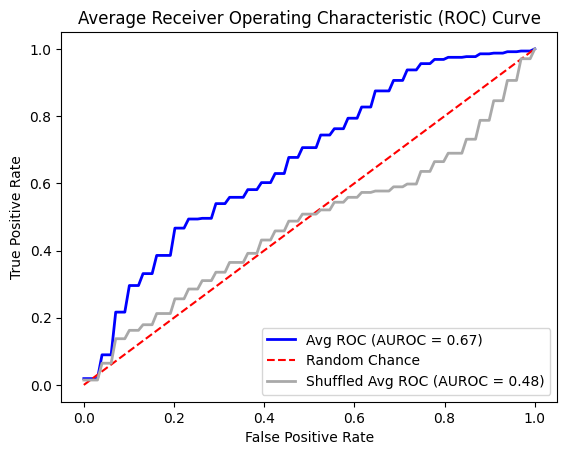

CURRENT WINDOW: 2 minutes


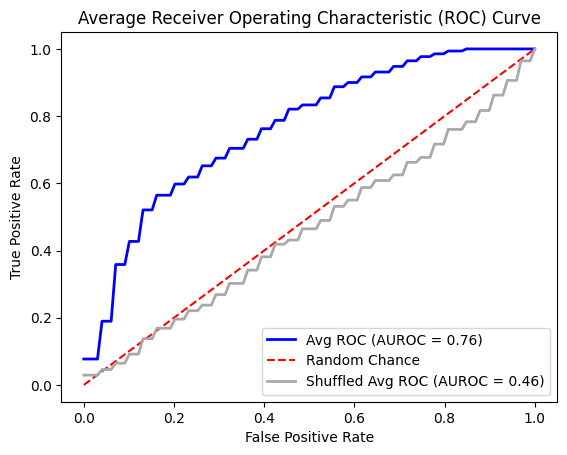

CURRENT WINDOW: 3 minutes


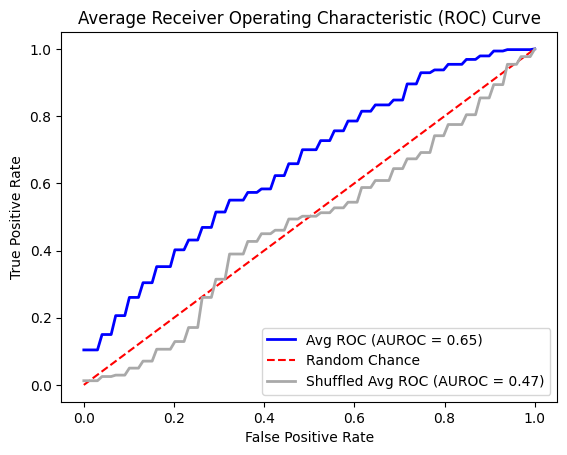

CURRENT WINDOW: 4 minutes


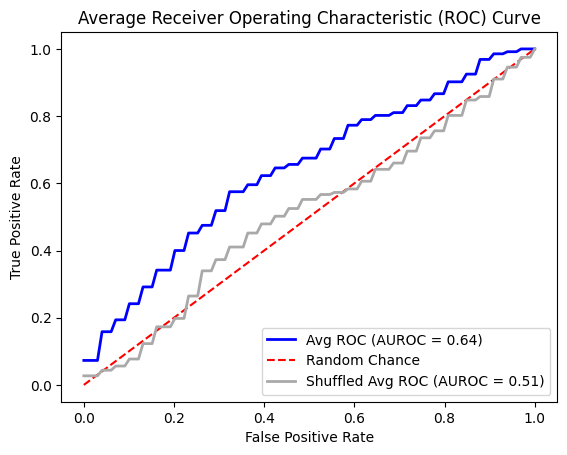

CURRENT WINDOW: 5 minutes


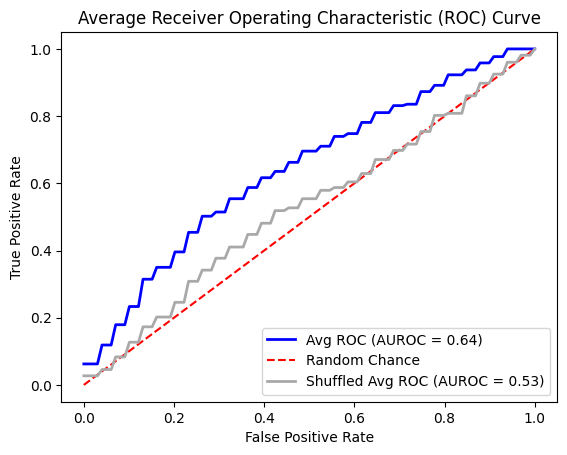

CURRENT WINDOW: 10 minutes


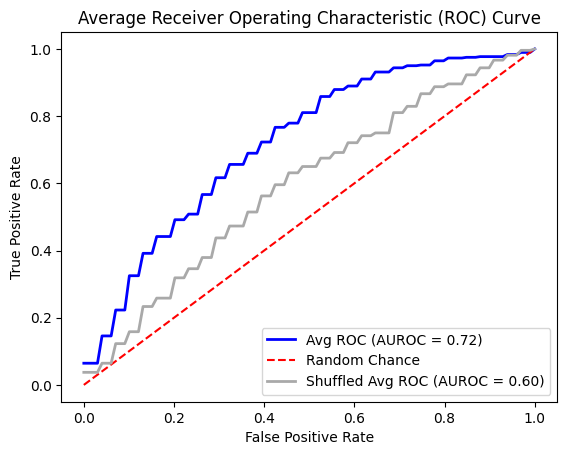

CURRENT WINDOW: 30 minutes


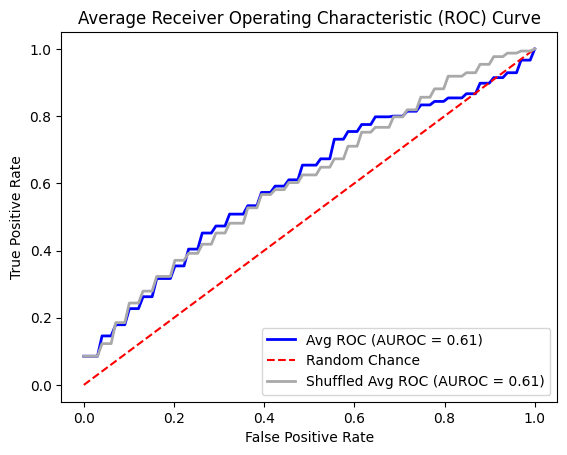

CURRENT WINDOW: 60 minutes


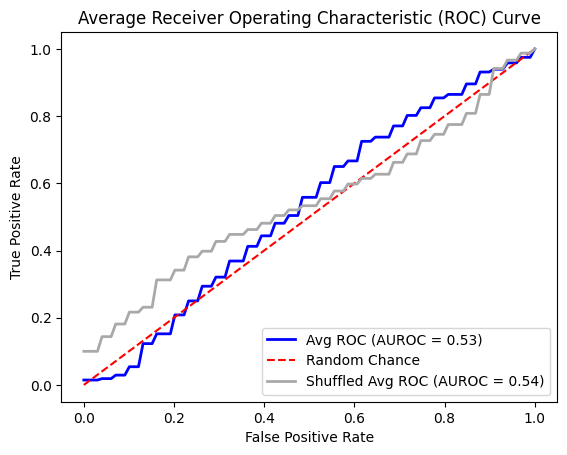

CURRENT WINDOW: 90 minutes


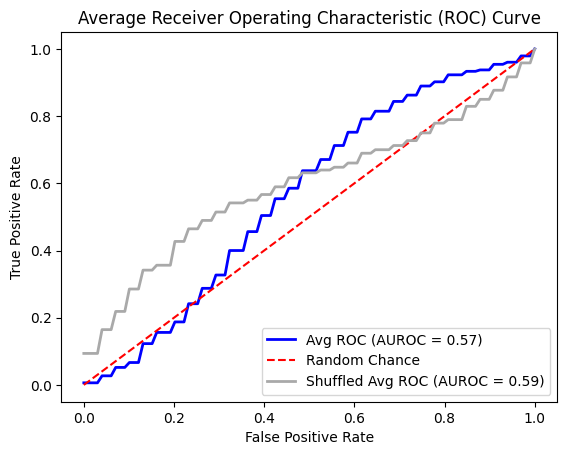

CURRENT WINDOW: 120 minutes


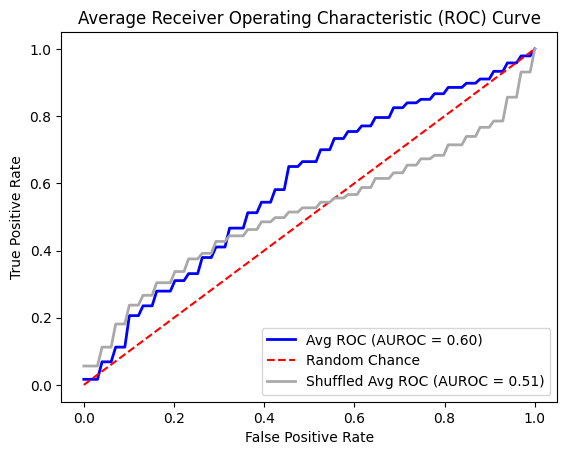

CURRENT WINDOW: 150 minutes


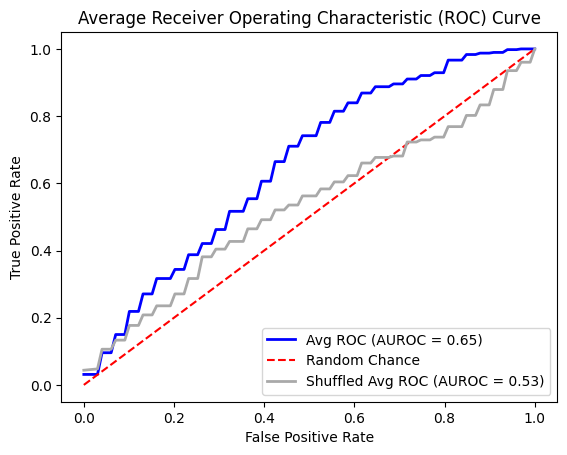

CURRENT WINDOW: 180 minutes


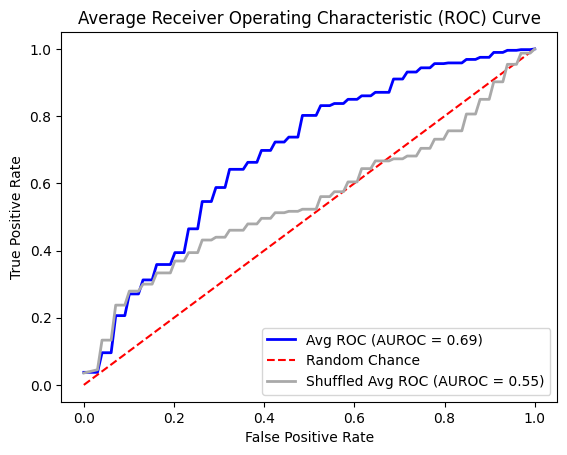

CURRENT WINDOW: 210 minutes


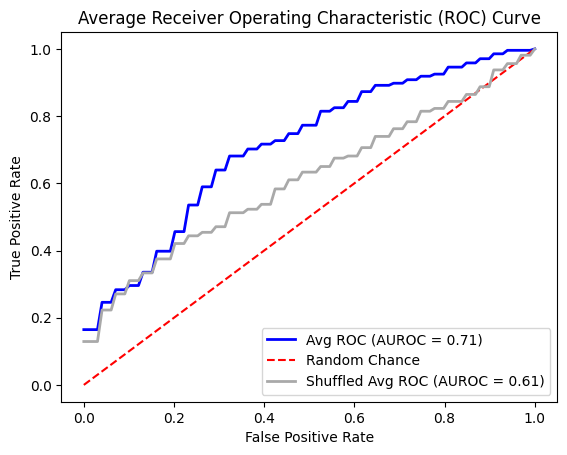

CURRENT WINDOW: 240 minutes


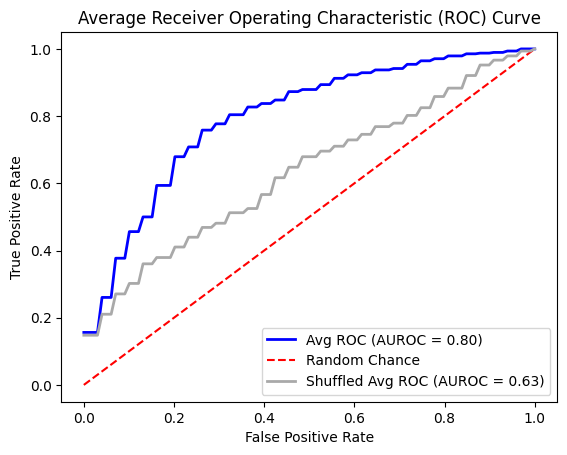

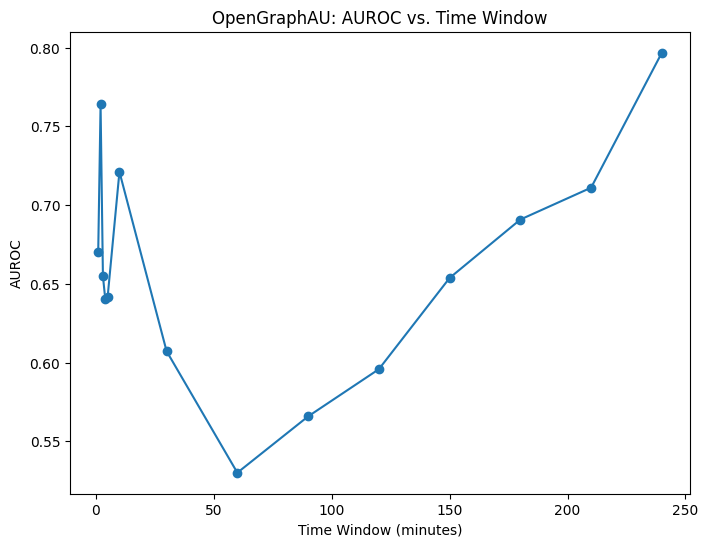

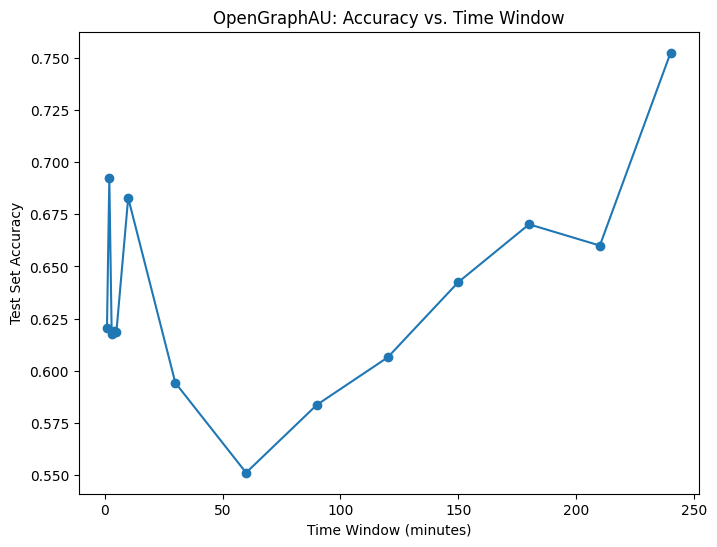

In [ ]:

pipeline_dict = {
    #'HSE': (hsemotion_vectors_dict, 'HSE_metrics.png', 'HSEmotion'),
    #'OFAU': (openface_vectors_dict, 'OFAU_metrics.png', 'OpenFace'),
    'OGAU': (opengraphau_vectors_dict, 'OGAU_metrics.png', 'OpenGraphAU'),
    #'OFAUHSE': (ofauhsemotion_vectors_dict, 'OFAUHSE_metrics.png', 'OFAU + HSE'),
    #'OGAUHSE': (ogauhsemotion_vectors_dict, 'OGAUHSE_metrics.png', 'OGAU + HSE'),
    #'ALL': (all_vectors_dict, 'ALL_metrics.png', 'ALL (OF + OG + HSE)')
}

# SHUFFLED LABELS
def shuffle_pain_column(df):
    # Make a copy of the DataFrame to avoid modifying the original one
    df_copy = df.copy()

    # Shuffle the 'Pain' column
    np.random.shuffle(df_copy['Pain'].values)

    return df_copy

set_seed(10)
shuffle_verbalPain = shuffle_pain_column(df_verbalPain)

ideal_windows = {}

for pipeline_label, (vectors_dict, save_file, title_prefix) in pipeline_dict.items():
  auroc_dict, acc_dict, auroc_dict_shuf, acc_dict_shuf  = get_metrics_binClass(vectors_dict, df_verbalPain, shuffle_verbalPain, save_path=RESULTS_PATH_BASE + "PAIN_LASSO/" + save_file, title=f'{title_prefix}: Automated Pain Detection', verbose=True)
  key_outputs_to_csv(auroc_dict, save_path=RESULTS_PATH_BASE + "PAIN_LASSO/" + save_file[:-4] + '.csv')
  save_auroc_dict_to_csv(auroc_dict, save_path=RESULTS_PATH_BASE + "PAIN_LASSO/" + 'AUROC_dict.csv')
  save_auroc_dict_to_csv(auroc_dict_shuf, save_path=RESULTS_PATH_BASE + "PAIN_LASSO/" + 'AUROC_shuffled_dict.csv')
  ideal_windows[pipeline_label] = max(auroc_dict, key=auroc_dict.get)
  plot_auroc_dict(auroc_dict, save_path=RESULTS_PATH_BASE + "PAIN_LASSO/" + save_file, title_prefix=title_prefix, verbose=True)
  plot_acc_dict(acc_dict, save_path=RESULTS_PATH_BASE + "PAIN_LASSO/" + save_file[:-4] + '_acc.png', title_prefix=title_prefix, verbose=True)

## Most Important AUs (OpenGraphAU Only)

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv

def analyze_au_pain(aus_one_time_window, df_verbalPain, save_path):
    # Splitting the timestamps into pain = 0 and pain = 1
    pain_0_times = df_verbalPain[df_verbalPain['Pain'] == 0]['Datetime']
    pain_1_times = df_verbalPain[df_verbalPain['Pain'] == 1]['Datetime']

    # Initialize dictionaries to hold pres_pct lists
    pres_pct_0 = {}
    pres_pct_1 = {}

    # Loop through each timestamp and categorize the pres_pct into pain 0 or 1
    for time, df in aus_one_time_window.items():
        if time in pain_0_times.values:
            for au in [i for i in df.columns if 'AU' in i]:
                if int(au.replace('AU', '')) not in pres_pct_0:
                    pres_pct_0[int(au.replace('AU', ''))] = []
                pres_pct_0[int(au.replace('AU', ''))].append(df[au]['pres_pct'])
        elif time in pain_1_times.values:
            for au in [i for i in df.columns if 'AU' in i]:
                if int(au.replace('AU', '')) not in pres_pct_1:
                    pres_pct_1[int(au.replace('AU', ''))] = []
                pres_pct_1[int(au.replace('AU', ''))].append(df[au]['pres_pct'])

    # Performing t-tests and calculating averages
    p_values = {}
    avg_pres_pct_0 = {}
    avg_pres_pct_1 = {}
    for au in pres_pct_0.keys():
        avg_pres_pct_0[au] = np.mean(pres_pct_0[au])
        avg_pres_pct_1[au] = np.mean(pres_pct_1[au])
        p_values[au] = stats.ttest_ind(pres_pct_0[au], pres_pct_1[au]).pvalue

    # Calculating SEM
    sem_pres_pct_0 = {}
    sem_pres_pct_1 = {}
    for au in pres_pct_0.keys():
        sem_pres_pct_0[au] = np.std(pres_pct_0[au]) / np.sqrt(len(pres_pct_0[au]))
        sem_pres_pct_1[au] = np.std(pres_pct_1[au]) / np.sqrt(len(pres_pct_1[au]))


    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))  # Wider figure
    for idx, au in enumerate(sorted(pres_pct_0.keys())):
        ax.bar(idx - 0.2, avg_pres_pct_0[au], width=0.4, color='blue', label='Low Pain' if idx == 0 else "", yerr=sem_pres_pct_0[au], capsize=5)
        ax.bar(idx + 0.2, avg_pres_pct_1[au], width=0.4, color='red', label='High Pain' if idx == 0 else "", yerr=sem_pres_pct_1[au], capsize=5)
        if p_values[au] < 0.05:
            #ax.plot([idx - 0.2, idx + 0.2], [max(avg_pres_pct_0[au], avg_pres_pct_1[au]) + 2, max(avg_pres_pct_0[au], avg_pres_pct_1[au]) + 2], color='black')
            #ax.plot([idx - 0.2, idx + 0.2], [max(avg_pres_pct_0[au], avg_pres_pct_1[au]) + 2, max(avg_pres_pct_0[au], avg_pres_pct_1[au]) + 2], color='black', linewidth=2)
            ax.scatter([idx - 0.2, idx, idx + 0.2], [max(avg_pres_pct_0[au], avg_pres_pct_1[au]) + 7.5]*3, color='black', marker='*', s=25)

    ax.set_xticks(range(len(pres_pct_0)))
    ax.set_xticklabels(sorted(pres_pct_0.keys()), fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=18)
    ax.set_ylabel('Average Presence (%)', fontsize=24)
    ax.set_xlabel('Facial Action Unit (AU)', fontsize=24)
    plt.title('Comparing Facial Action Units During Low vs. High Pain', fontsize=26)
    ax.legend(fontsize=24)
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    return p_values, avg_pres_pct_0, avg_pres_pct_1, sem_pres_pct_0, sem_pres_pct_1


def save_dicts_to_csv(dict1, dict2, dict3, error_dict1, error_dict2, save_path):
    """
    Save five dictionaries to a CSV file.

    :param dict1: Dictionary for 'Low Pain Presence Percent'
    :param dict2: Dictionary for 'High Pain Presence Percent'
    :param dict3: Dictionary for 'P value'
    :param error_dict1: Dictionary for 'SEM Low Pain'
    :param error_dict2: Dictionary for 'SEM High Pain'
    :param save_path: The path to save the CSV file
    """
    fieldnames = ['AU', 'Low Pain Presence Percent', 'SEM Low Pain', 'High Pain Presence Percent', 'SEM High Pain', 'P value']

    with open(save_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Assuming all dictionaries have the same keys
        for key in dict1:
            writer.writerow({
                'AU': key,
                'Low Pain Presence Percent': dict1[key],
                'SEM Low Pain': error_dict1[key],
                'High Pain Presence Percent': dict2[key],
                'SEM High Pain': error_dict2[key],
                'P value': dict3[key]
            })



In [ ]:
pipeline_label = 'OGAU'
dict_list_dict = opengraphau_dict_list_dict
save_file_prefix = 'OGAU_AU_comparison'
title_prefix = 'OpenGraphAU'


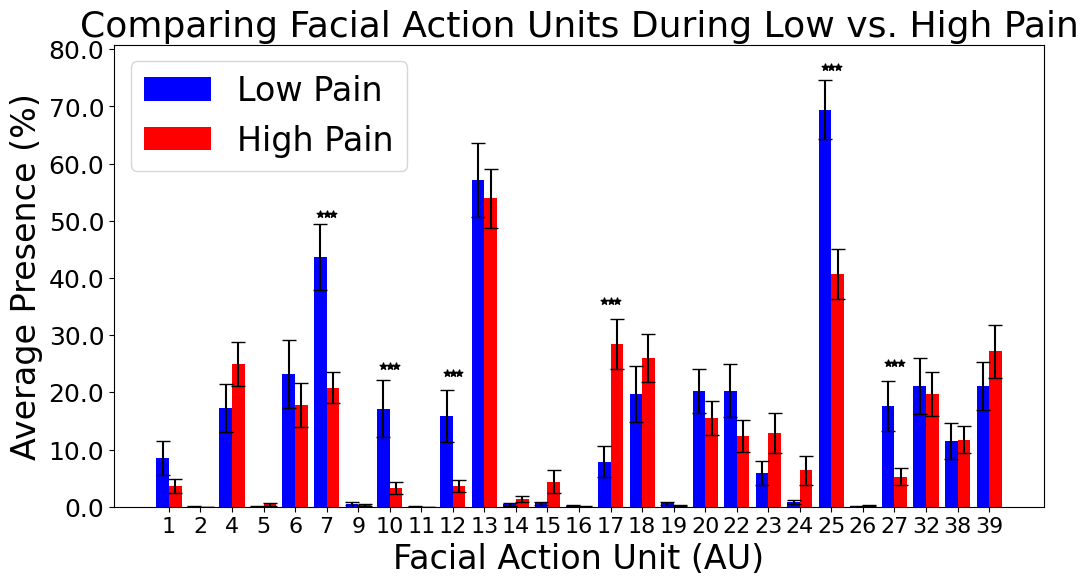

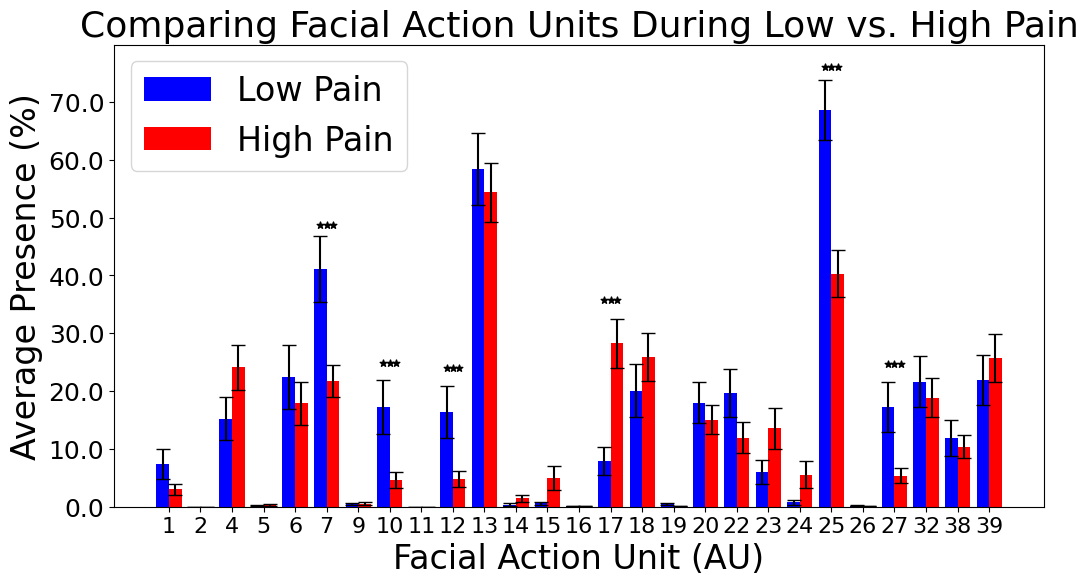

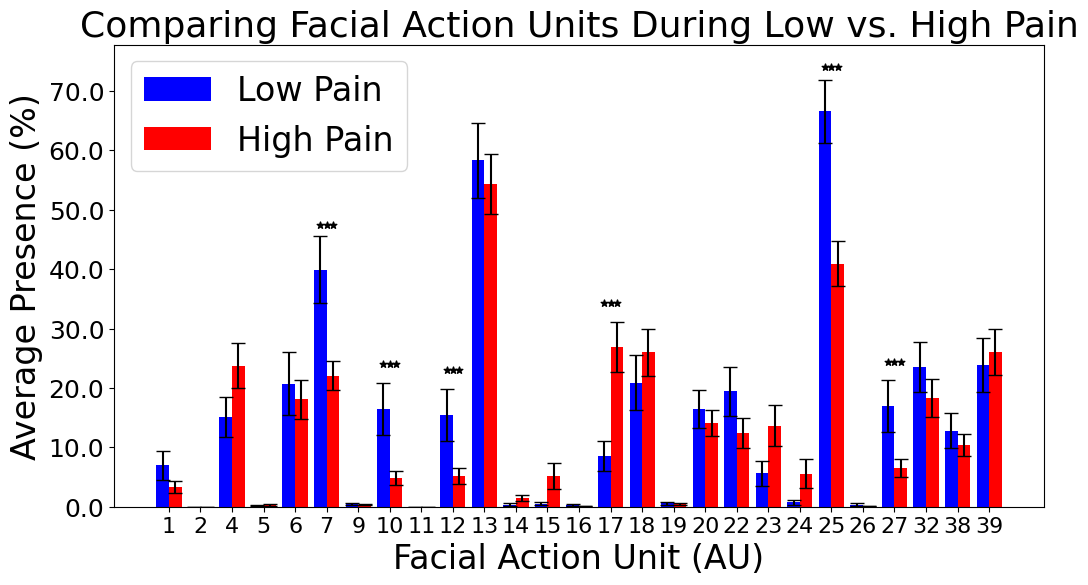

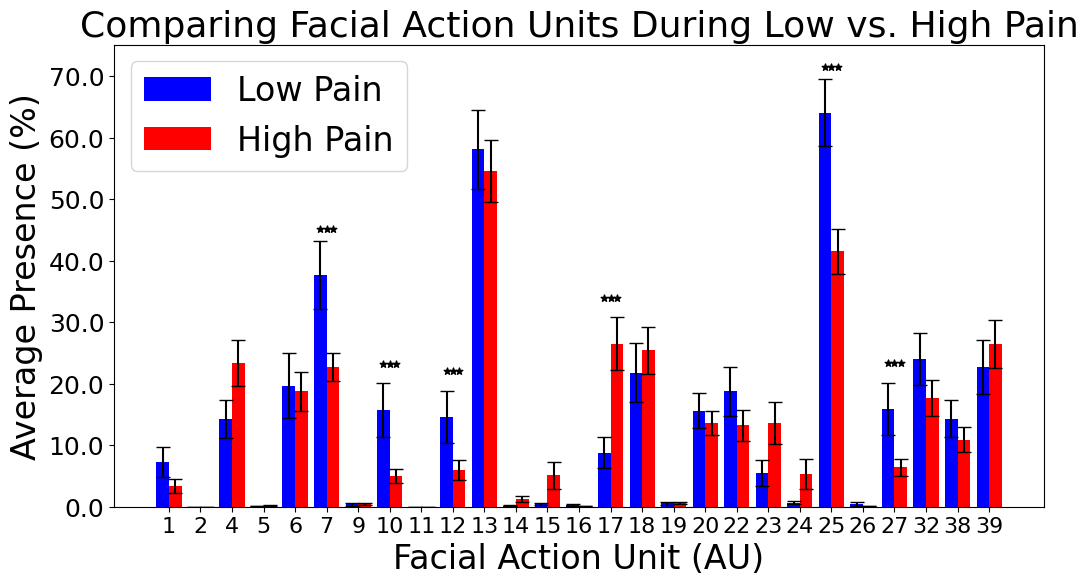

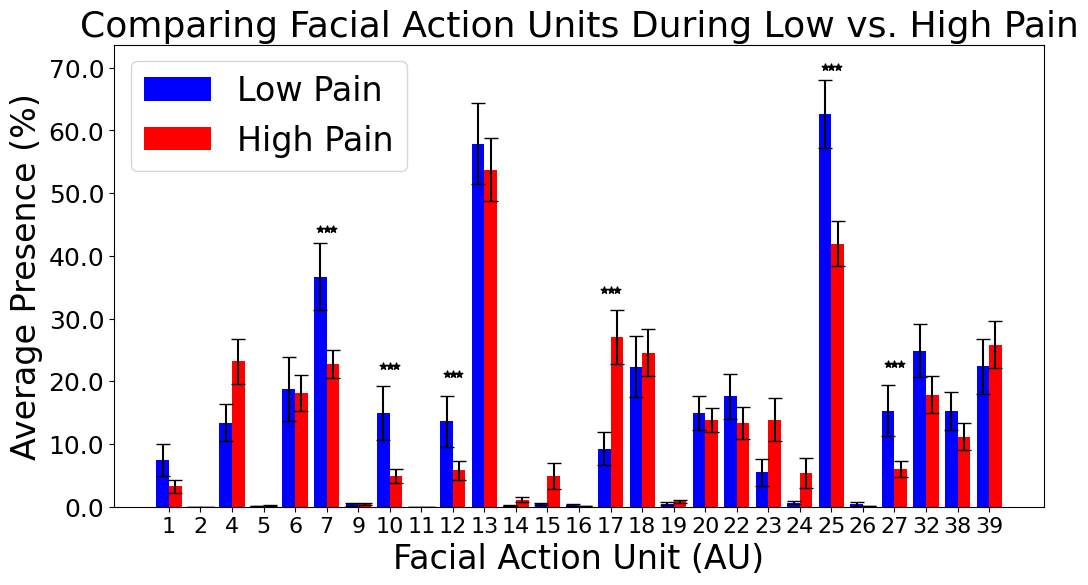

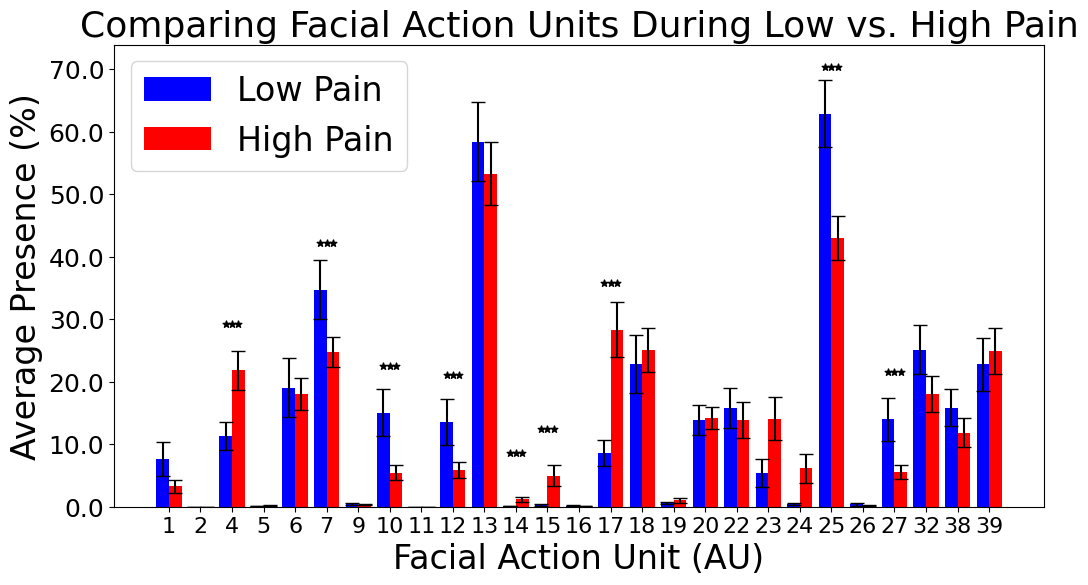

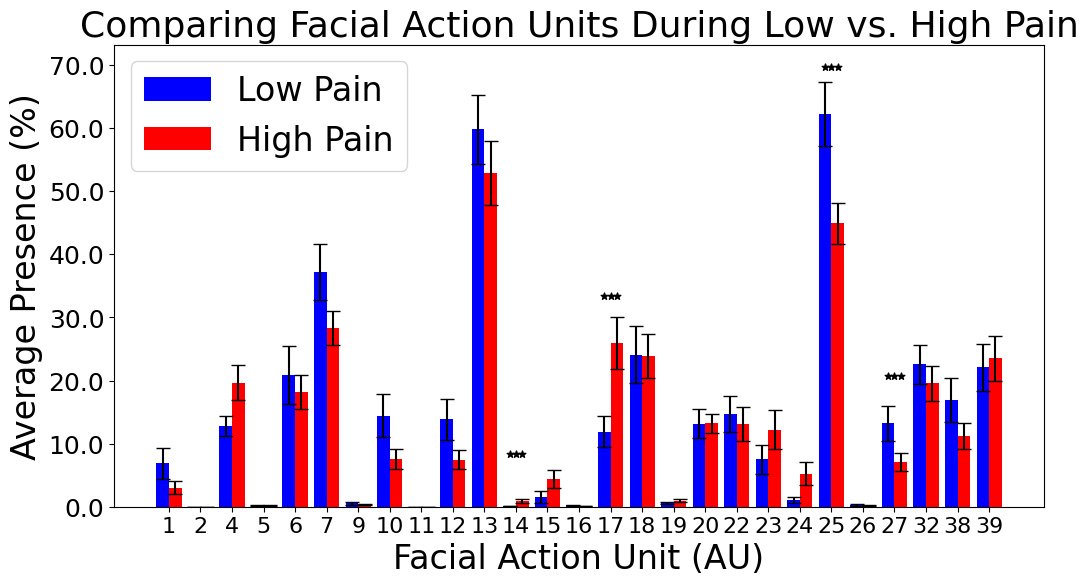

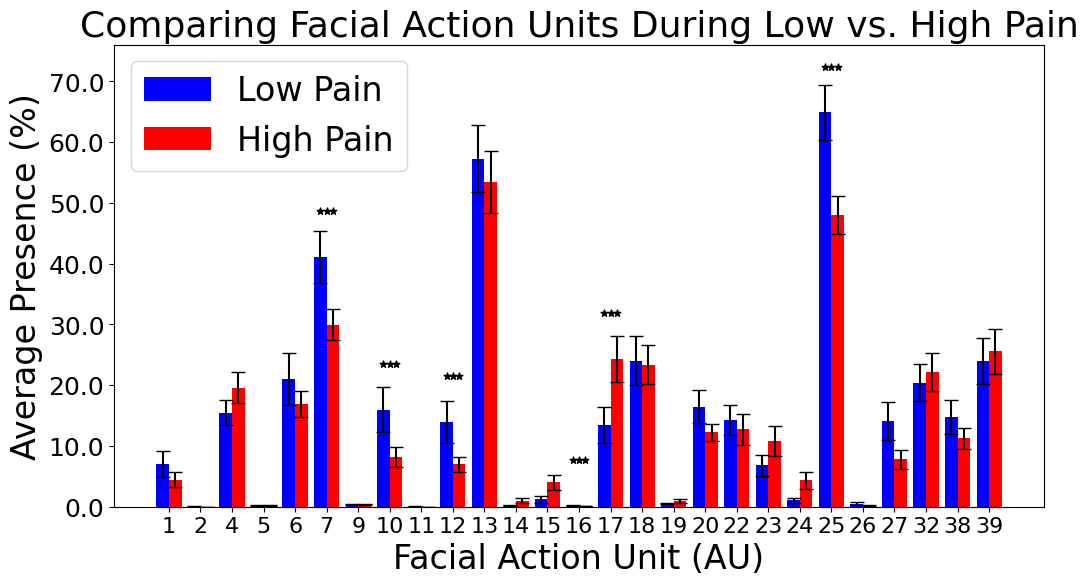

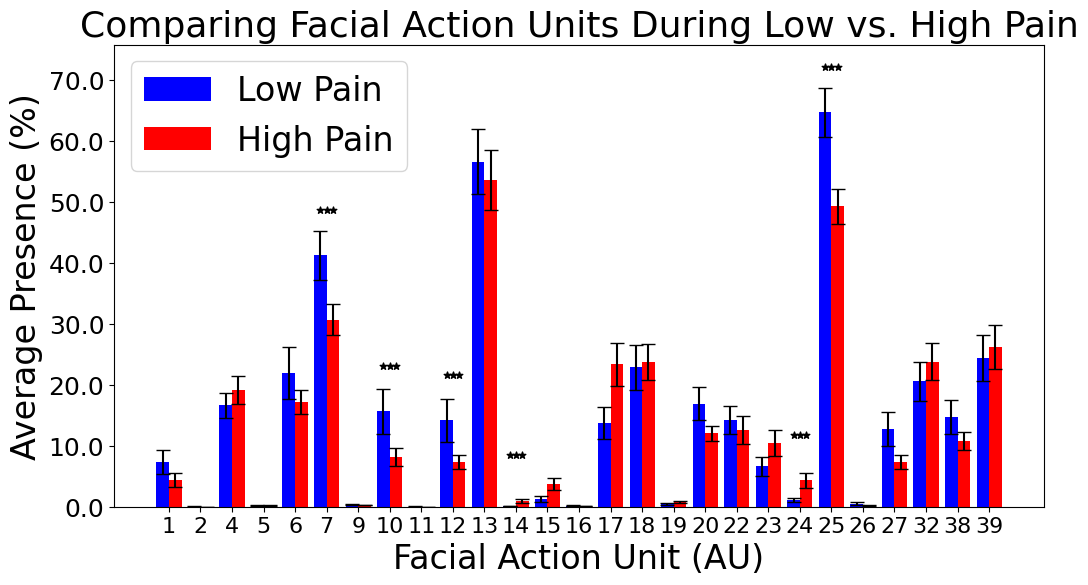

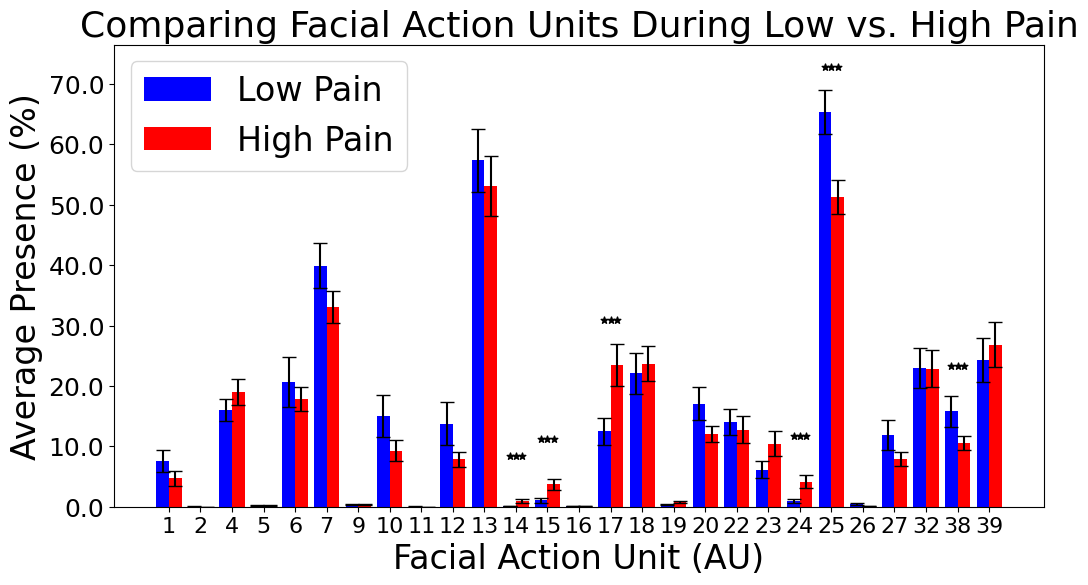

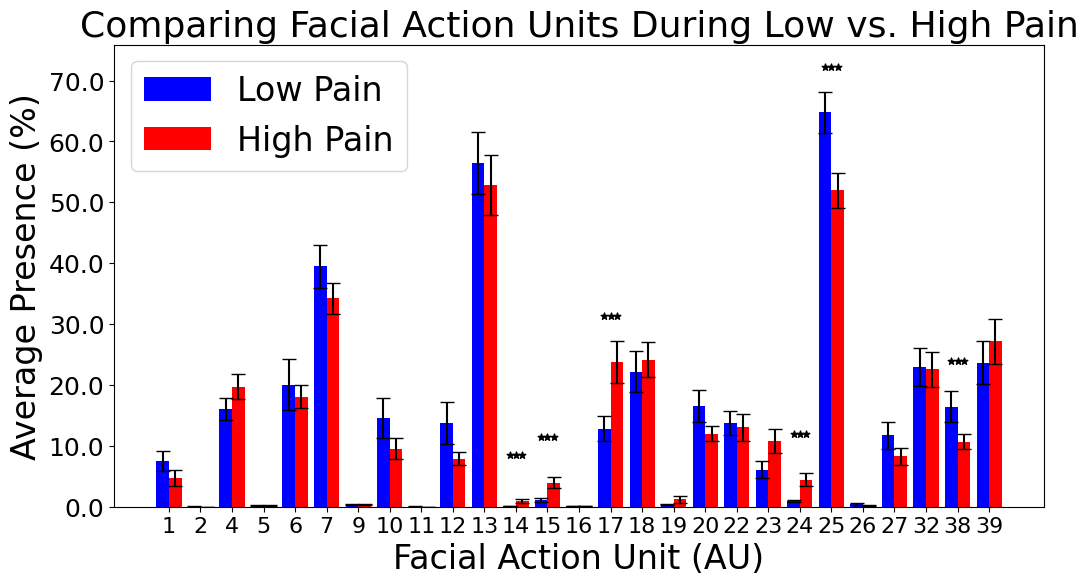

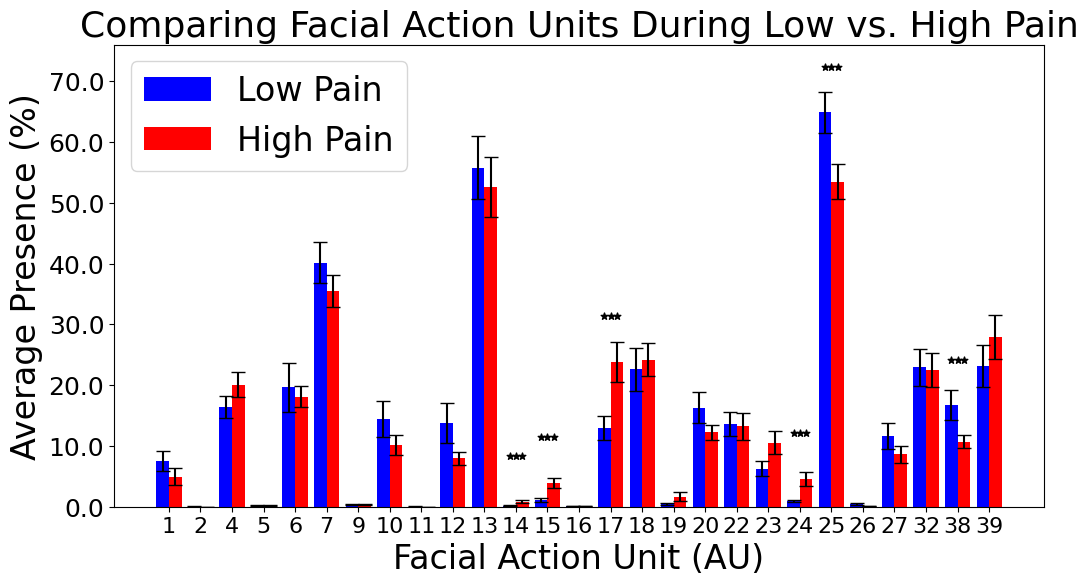

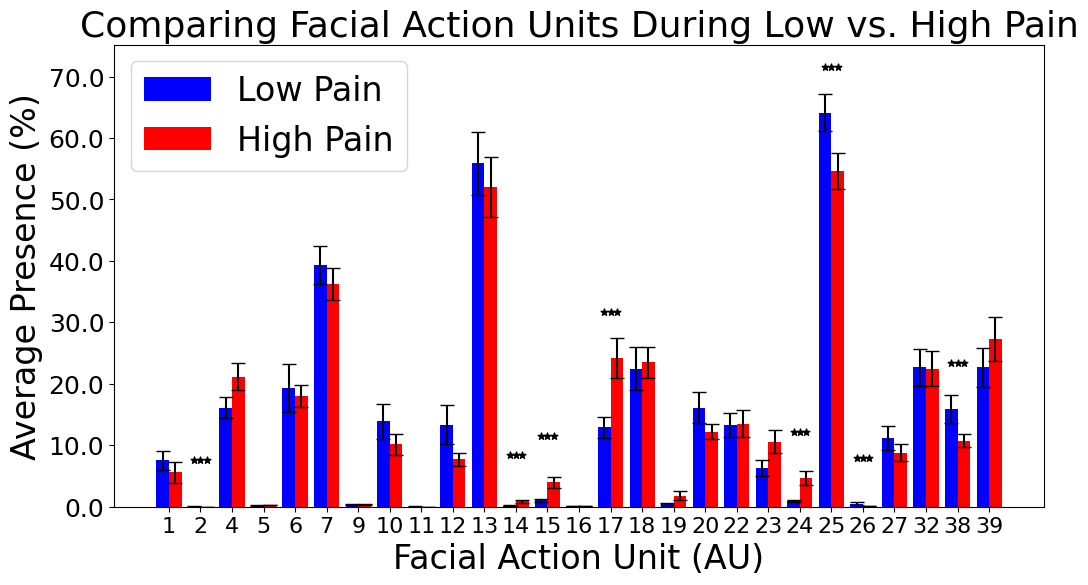

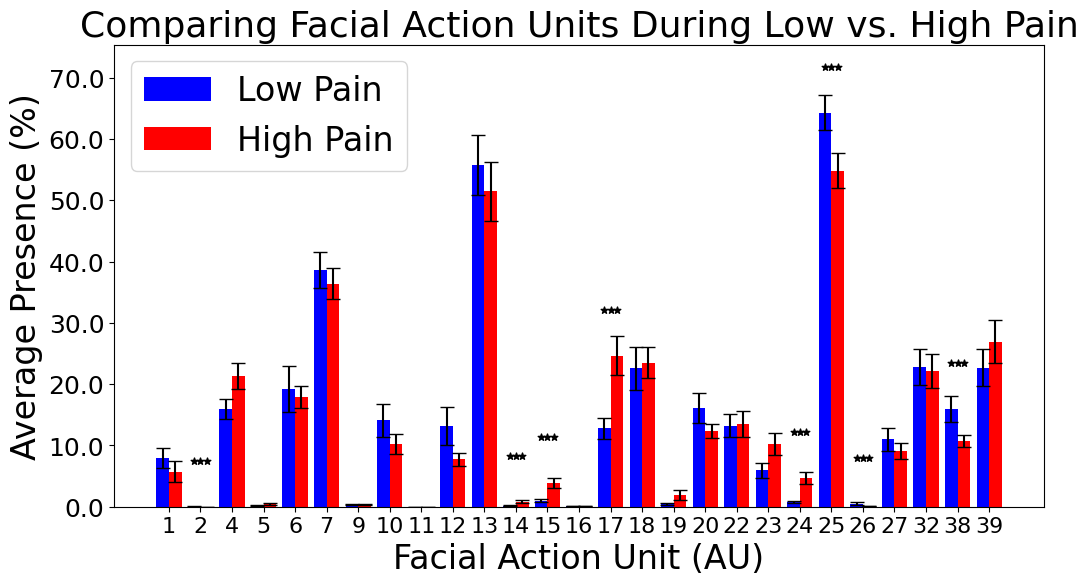

In [ ]:
for ideal_window in dict_list_dict.keys():
  save_file = f'{save_file_prefix}_{ideal_window}.png'
  aus_one_time_window = dict_list_dict[ideal_window][0] # the first list element is the au derived dict!
  barplot_save_path = RESULTS_PATH_BASE + "PAIN_LASSO/" + save_file
  p_values, avg_pres_pct_0, avg_pres_pct_1, sem_pres_pct_0, sem_pres_pct_1 = analyze_au_pain(aus_one_time_window, df_verbalPain, barplot_save_path)
  save_dicts_to_csv(avg_pres_pct_0, avg_pres_pct_1, p_values, sem_pres_pct_0, sem_pres_pct_1, save_path=RESULTS_PATH_BASE + "PAIN_LASSO/" + f'Significant_AUs_{ideal_window}_minutes.csv')

In [ ]:
aus_one_time_window[list(aus_one_time_window.keys())[0]]

,AU20,AU1,AU18,AU4,AU22,AU12,AU16,AU6,AU2,AU26,...,AU39,AU32,AU24,AU9,AU23,AU7,AU14,AU5,AU25,AU11
pres_pct,60.0,0.0,26.896552,8.62069,3.103448,92.068966,0.0,100.0,0.0,0.0,...,20.344828,7.931034,0.0,0.0,0.0,95.862069,0.0,0.0,97.931034,0.0
total_num_events,1.0,0.0,0.000000,1.00000,0.000000,1.000000,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0
